In [3]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import logging

In [4]:
plt.rcParams['figure.figsize']=(15,15) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(dpi=150, dpi_save=300, format='svg')
sc.logging.print_versions()

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


# User inputs

In [5]:
adata_mnn_final = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_full_mnn_final.h5ad'

adata_mnn_full_noCC_velo = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_full_mnn_noCC_scvelo_dyn.h5ad'

# Load data

In [6]:
adata = sc.read(adata_mnn_final)
adata_velo = sc.read(adata_mnn_full_noCC_velo)

In [7]:
adata
adata_velo

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'donor', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'louvain_final_nohvg', 'louvain_prefinal_nohvg', 'condition', 'age', 'years_of_illness', 'gender', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'donor_colors', 'gender_colors', 'louvain', 'louvain_final_colors', 'louvain_final_nohvg_co

AnnData object with n_obs × n_vars = 24956 × 15705 
    obs: 'Demux_state', 'Donor', 'Lane', 'donor', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'louvain_final_nohvg', 'louvain_prefinal_nohvg', 'condition', 'age', 'years_of_illness', 'gender', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_r0.2_noCC_3_sub', 'louvain_r0.2_noCC_NCSC_sub', 'test_groups', 'louvain_final', 'sample', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain_final_coarse', 'velocity_self_transition', 'NSC_root_cell'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'f

# GWAS gene analysis

In [8]:
GWAS_genes = ['KRTCAP2', 'NUCKS1', 'GBA', 'SIPA1L2', 'ITPKB', 'MAP4K4', 'PMVK', 'STK39', 'RAB29', 'TMEM163', 'SATB1', 'IP6K2', 'TMEM175', 'MCCC1', 'BST1', 'GAK', 'FAM47E', 'SCARB2', 'SNCA', 'HLA-DRB5', 'ELOVL7', 'FAM47E-STBD1', 'CAMK2D', 'GPNMB', 'CTSB', 'LOC100131289', 'SH3GL2', 'FGF20', 'BIN3', 'ITGA8', 'LRRK2', 'INPP5F', 'IGSF9B', 'BAG3', 'DLG2', 'HIP1R', 'GCH1', 'CHD9', 'GALC', 'VPS13C', 'CASC16', 'SYT17', 'CRHR1', 'SETD1A', 'RETREG3', 'WNT3', 'RIT2', 'SPPL2B', 'FCGR2A', 'VAMP4', 'KCNS3', 'KCNIP3', 'LINC00693', 'KPNA1', 'MED12L', 'SPTSSB', 'LCORL', 'CLCN3', 'PAM', 'C5orf24', 'TRIM40', 'RIMS1', 'FYN', 'RPS12', 'GS1-124K5.11', 'FAM49B', 'UBAP2', 'GBF1', 'RNF141', 'SCAF11', 'FBRSL1', 'CAB39L', 'MBNL2', 'MIPOL1', 'RPS6KL1', 'CD19', 'NOD2', 'CHRNB1', 'UBTF', 'FAM171A2', 'BRIP1', 'DNAH17', 'ASXL3', 'MEX3C', 'CRLS1', 'DYRK1A']

down_gwas_genes = ['RIT2', 'VPS13C', 'GBA', 'RAB29', 'GCH1']
up_gwas_genes = ['LRRK2', 'GPNMB', 'NOD2', 'SCARB2', 'KPNA1']

In [9]:
GWAS_genes_filtered = [gene for gene in GWAS_genes if gene in adata.var_names]
up_gwas_genes_filtered = [gene for gene in up_gwas_genes if gene in adata.var_names]
down_gwas_genes_filtered = [gene for gene in down_gwas_genes if gene in adata.var_names]


In [10]:
len(GWAS_genes)
len(GWAS_genes_filtered)
len(up_gwas_genes_filtered)
len(down_gwas_genes_filtered)

86

77

5

5

In [33]:
sc.tl.score_genes(adata, GWAS_genes_filtered, score_name='gwas_score', )
sc.tl.score_genes(adata, up_gwas_genes_filtered, score_name='gwas_score_up')
sc.tl.score_genes(adata, down_gwas_genes_filtered, score_name='gwas_score_down')

computing score 'gwas_score'
    finished (0:00:06)
computing score 'gwas_score_up'
    finished (0:00:05)
computing score 'gwas_score_down'
    finished (0:00:05)


Text(0.5, 1.0, 'Glial prec. (myelinating)')

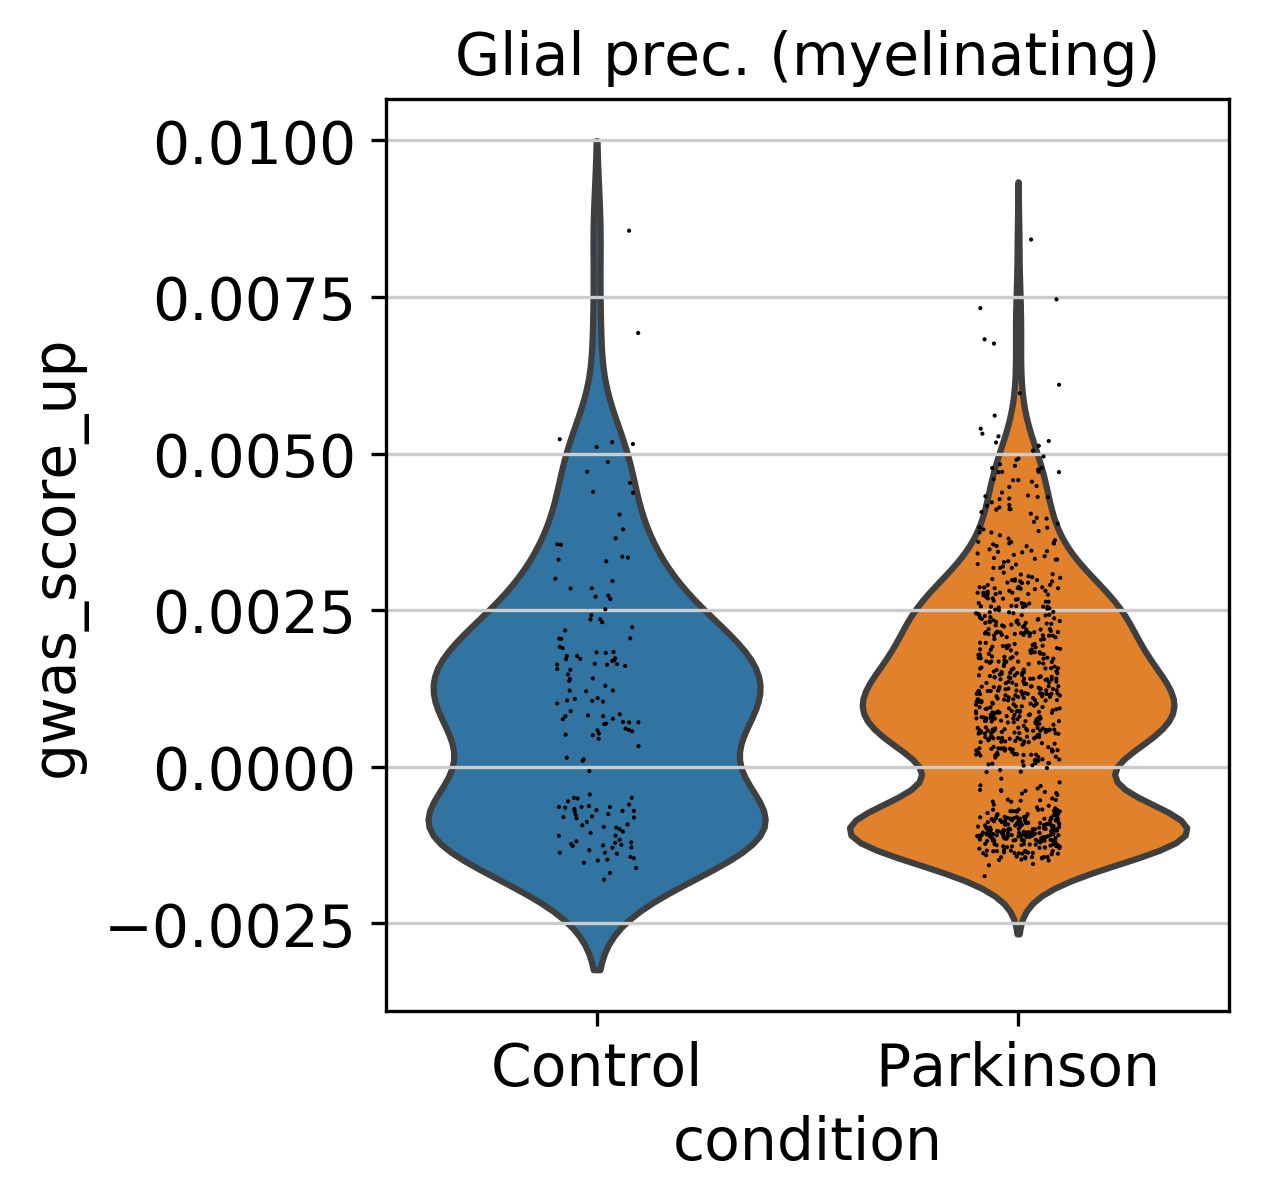

Text(0.5, 1.0, 'NCSC')

Text(0.5, 1.0, 'Apop. NCSC')

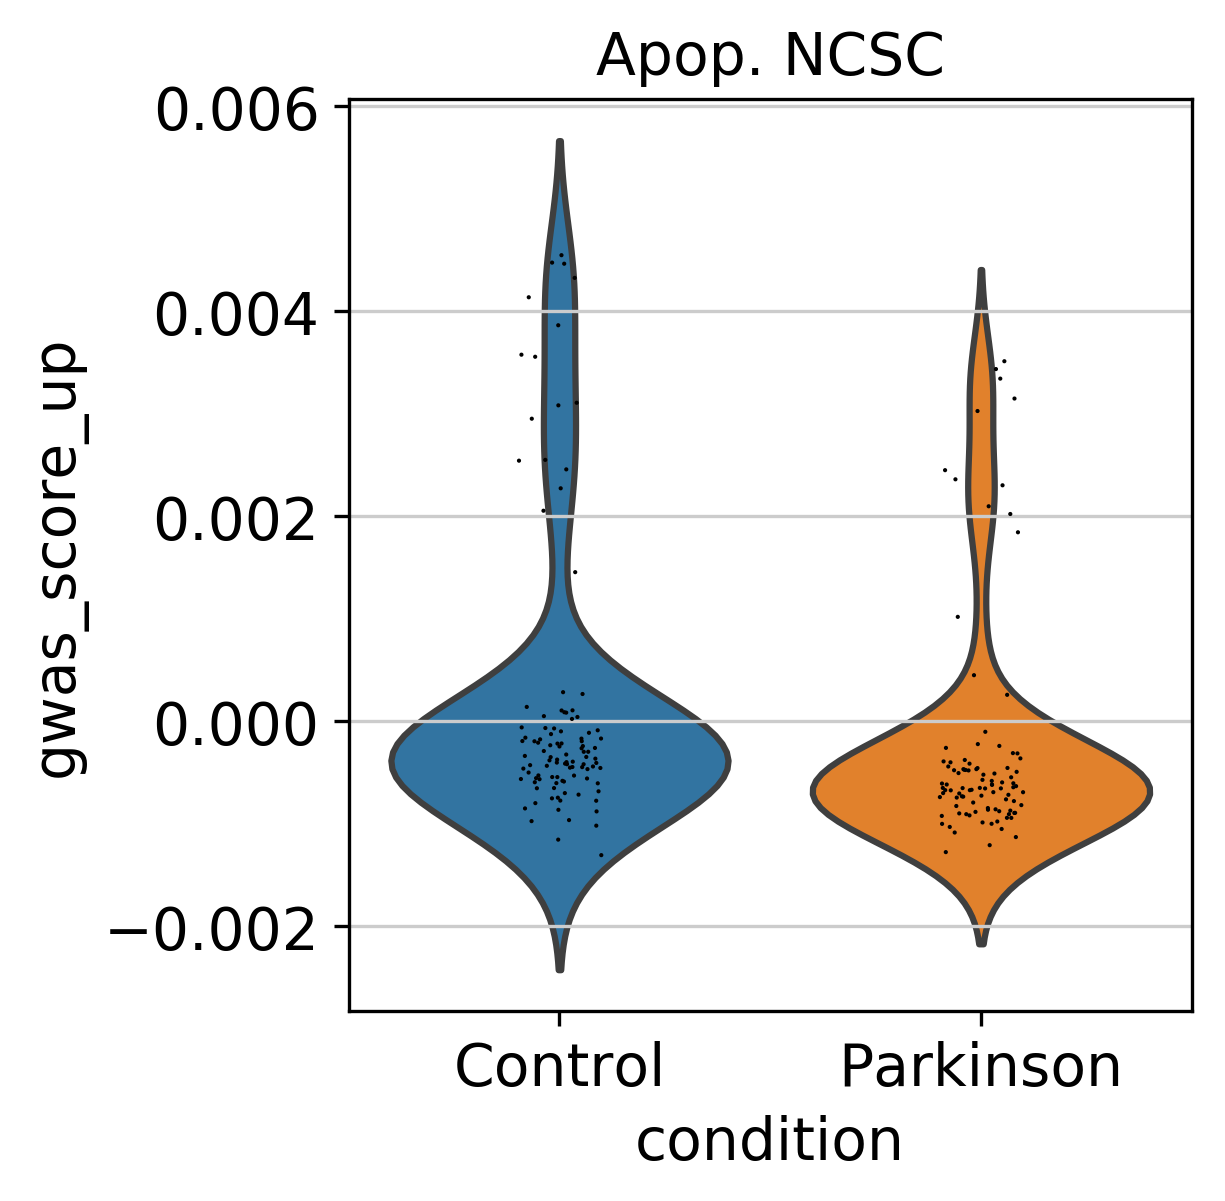

Text(0.5, 1.0, 'NSC2')

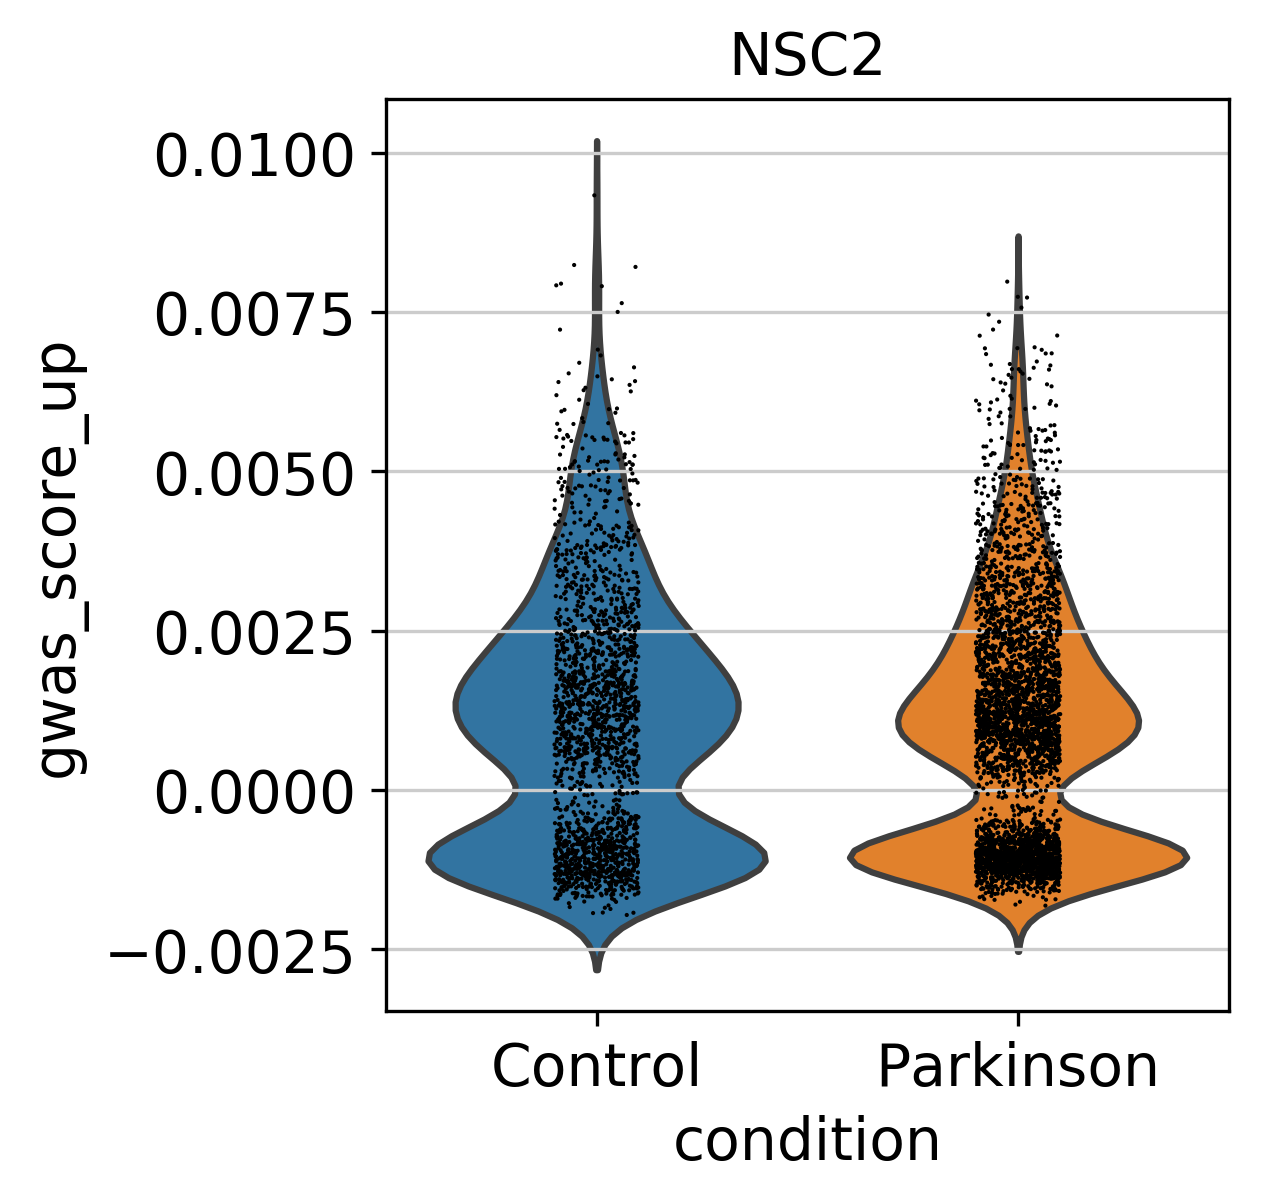

Text(0.5, 1.0, 'NSC2 (G2M)')

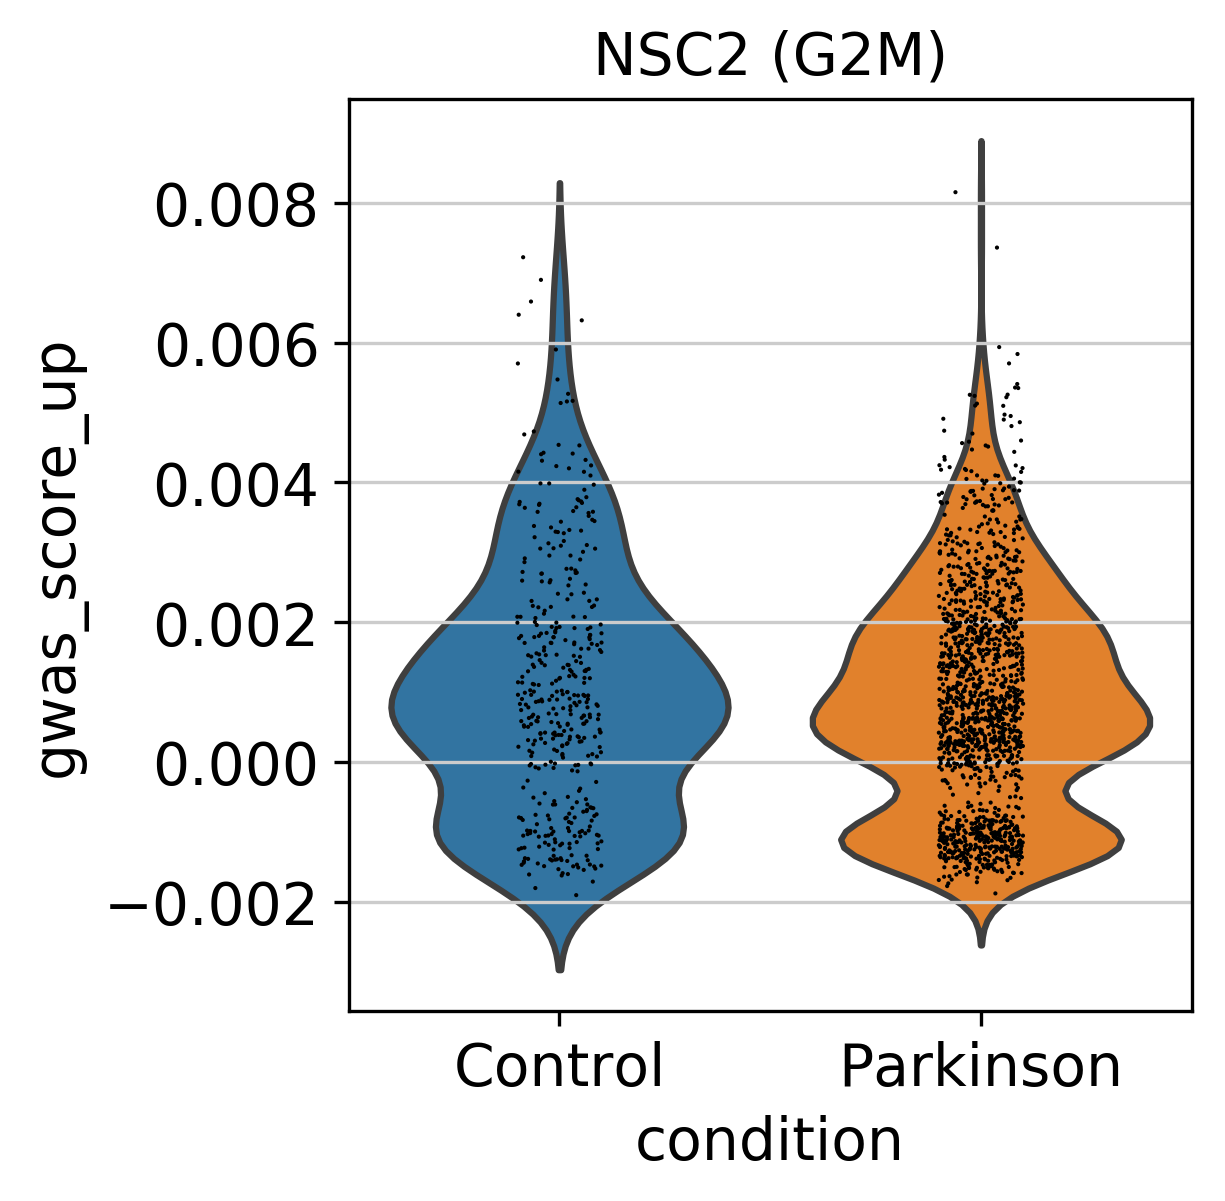

Text(0.5, 1.0, 'NSC1')

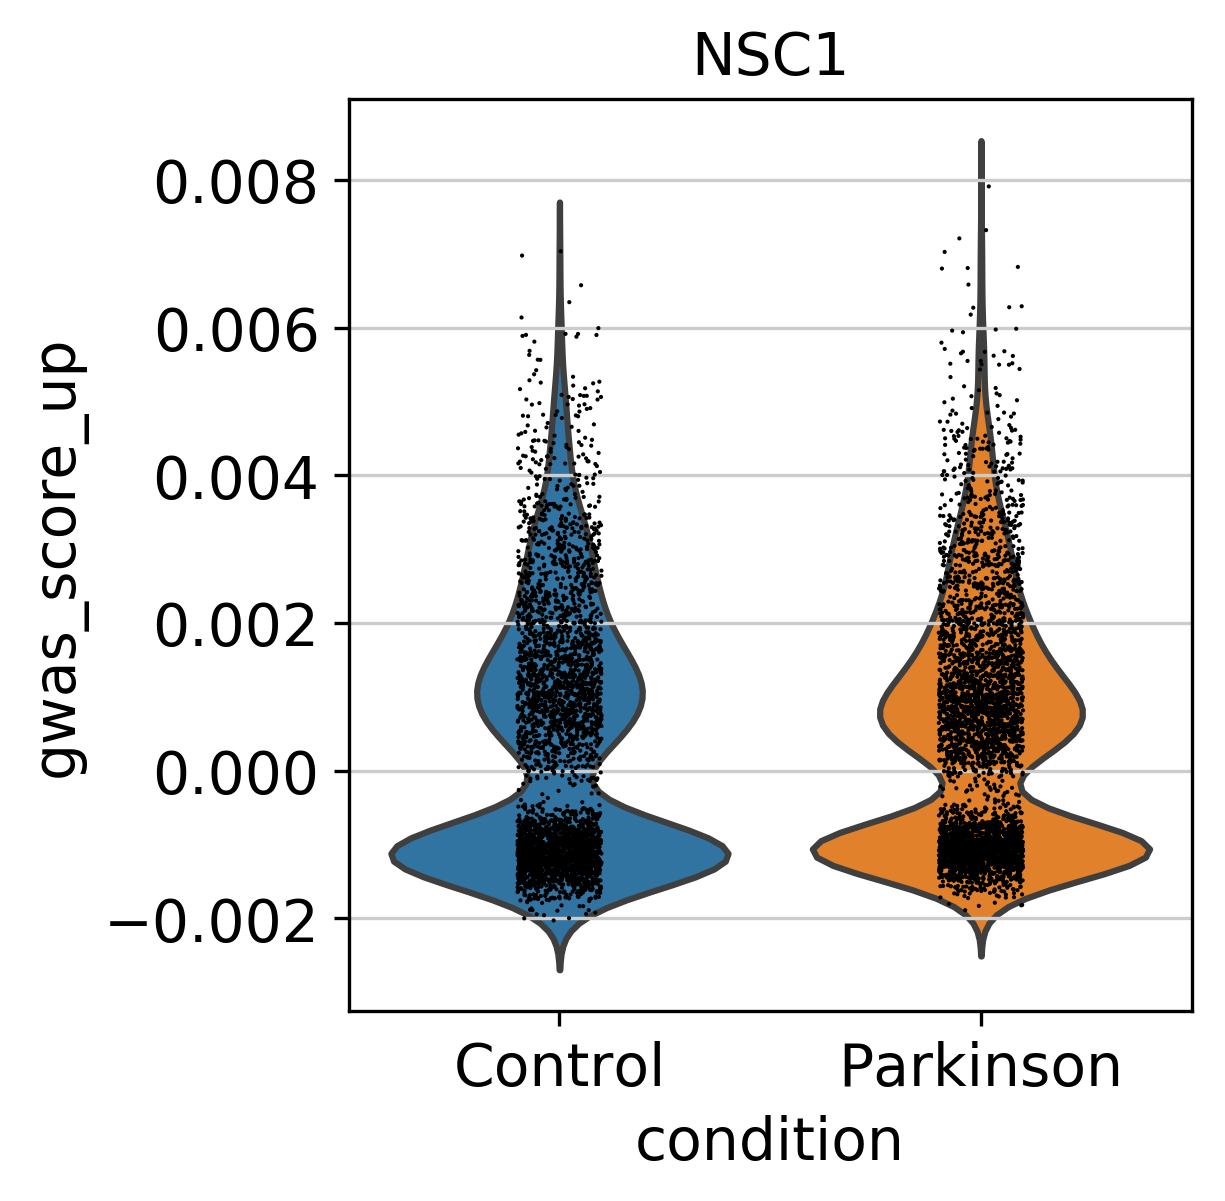

Text(0.5, 1.0, 'NSC1 (G2M)')

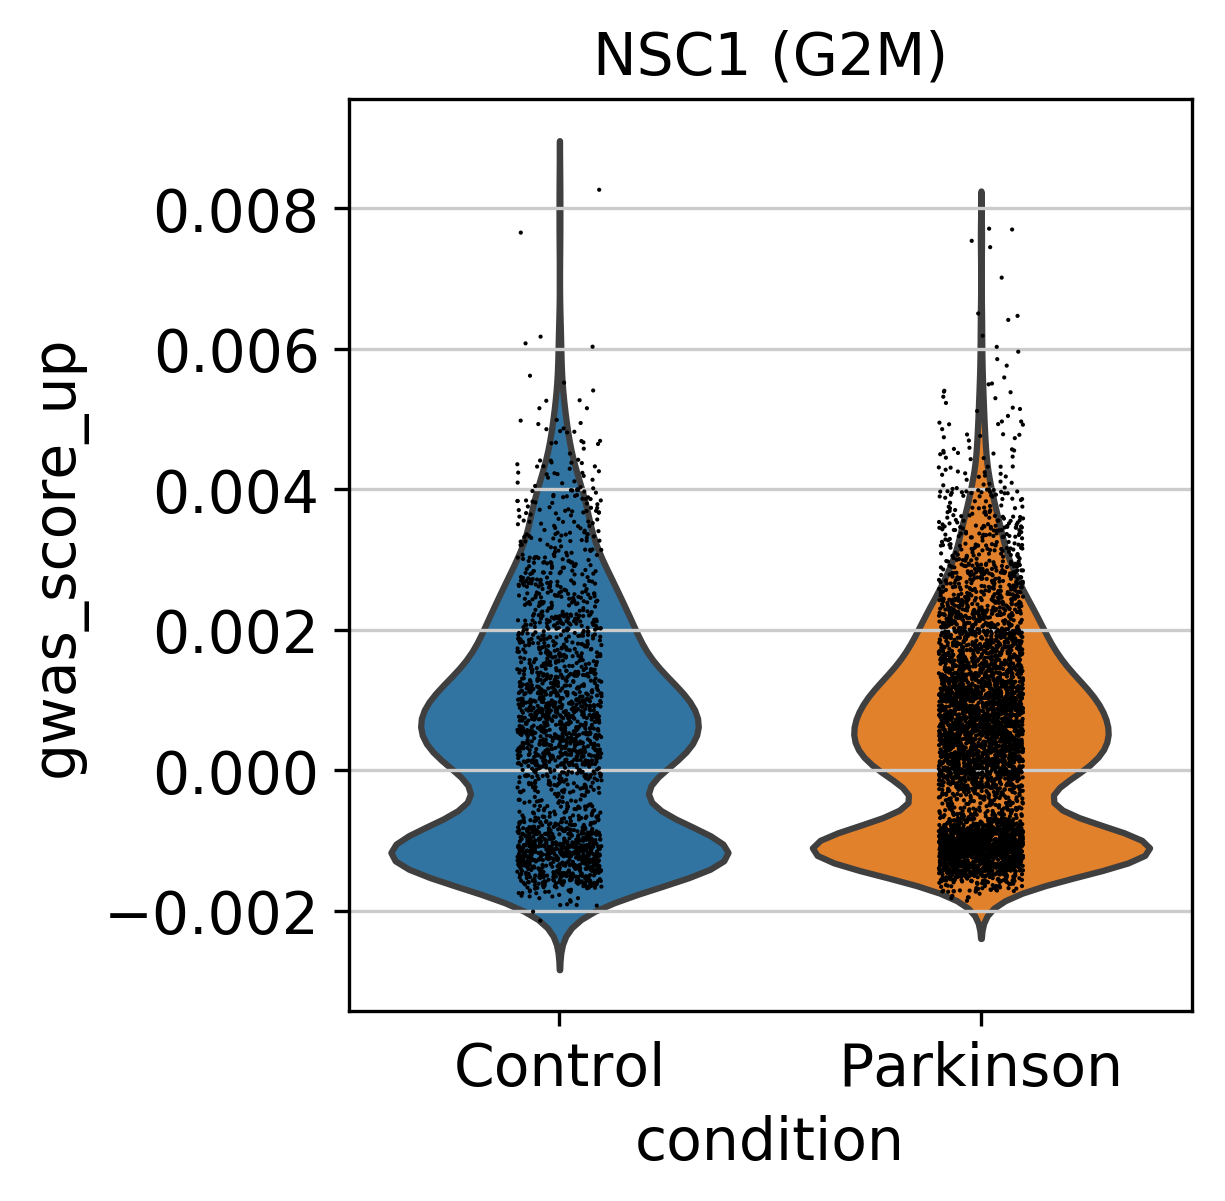

Text(0.5, 1.0, 'immature neurons')

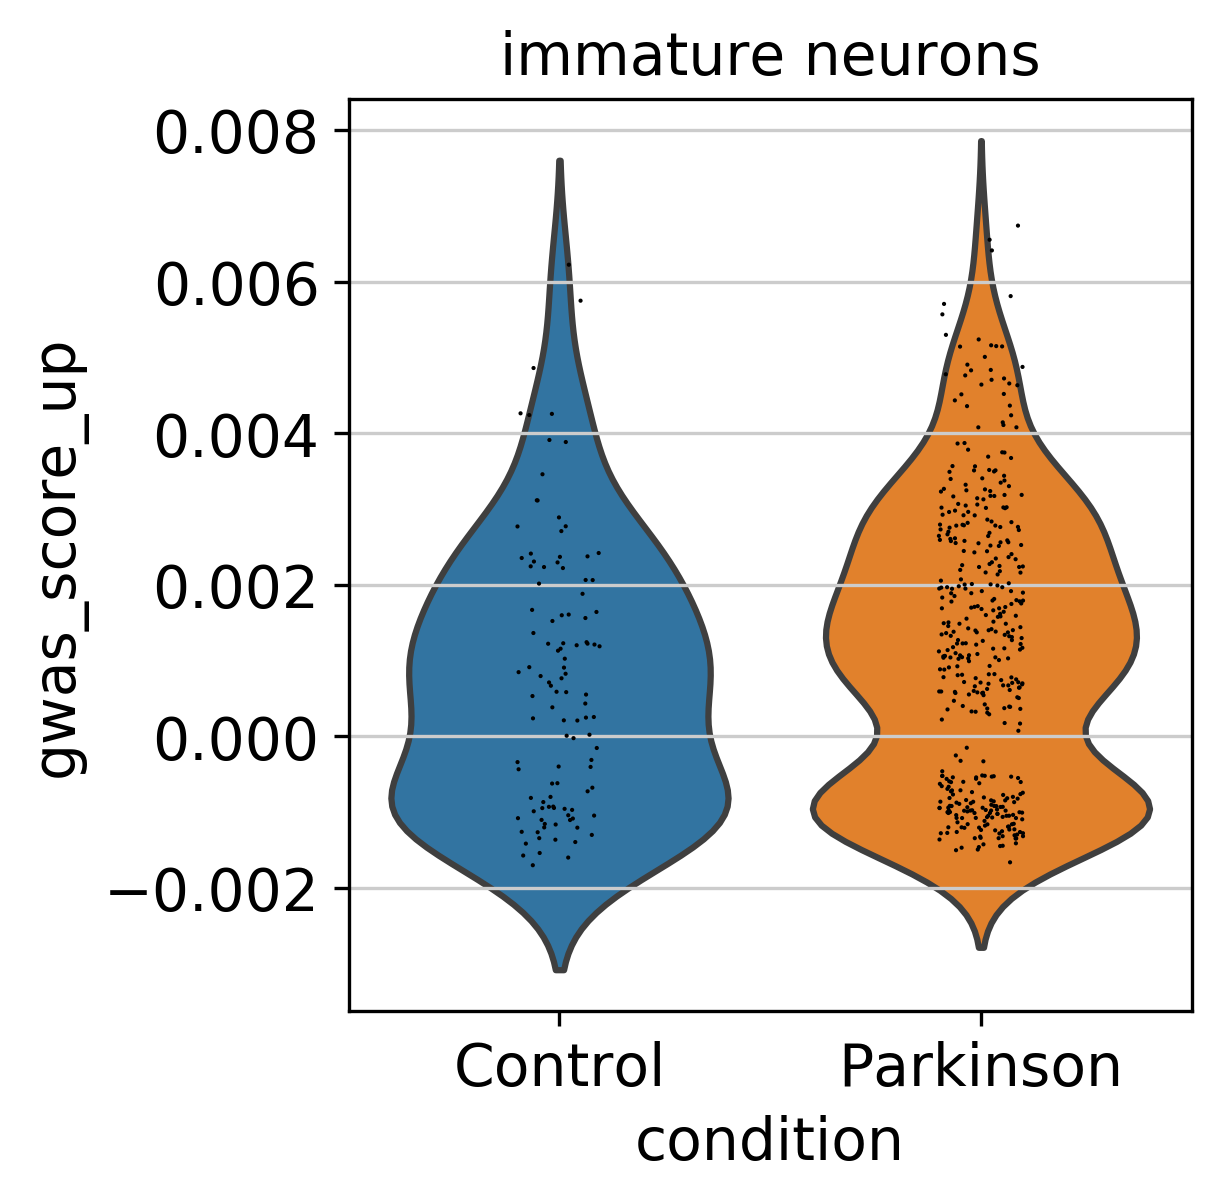

Text(0.5, 1.0, 'Apop. NSC')

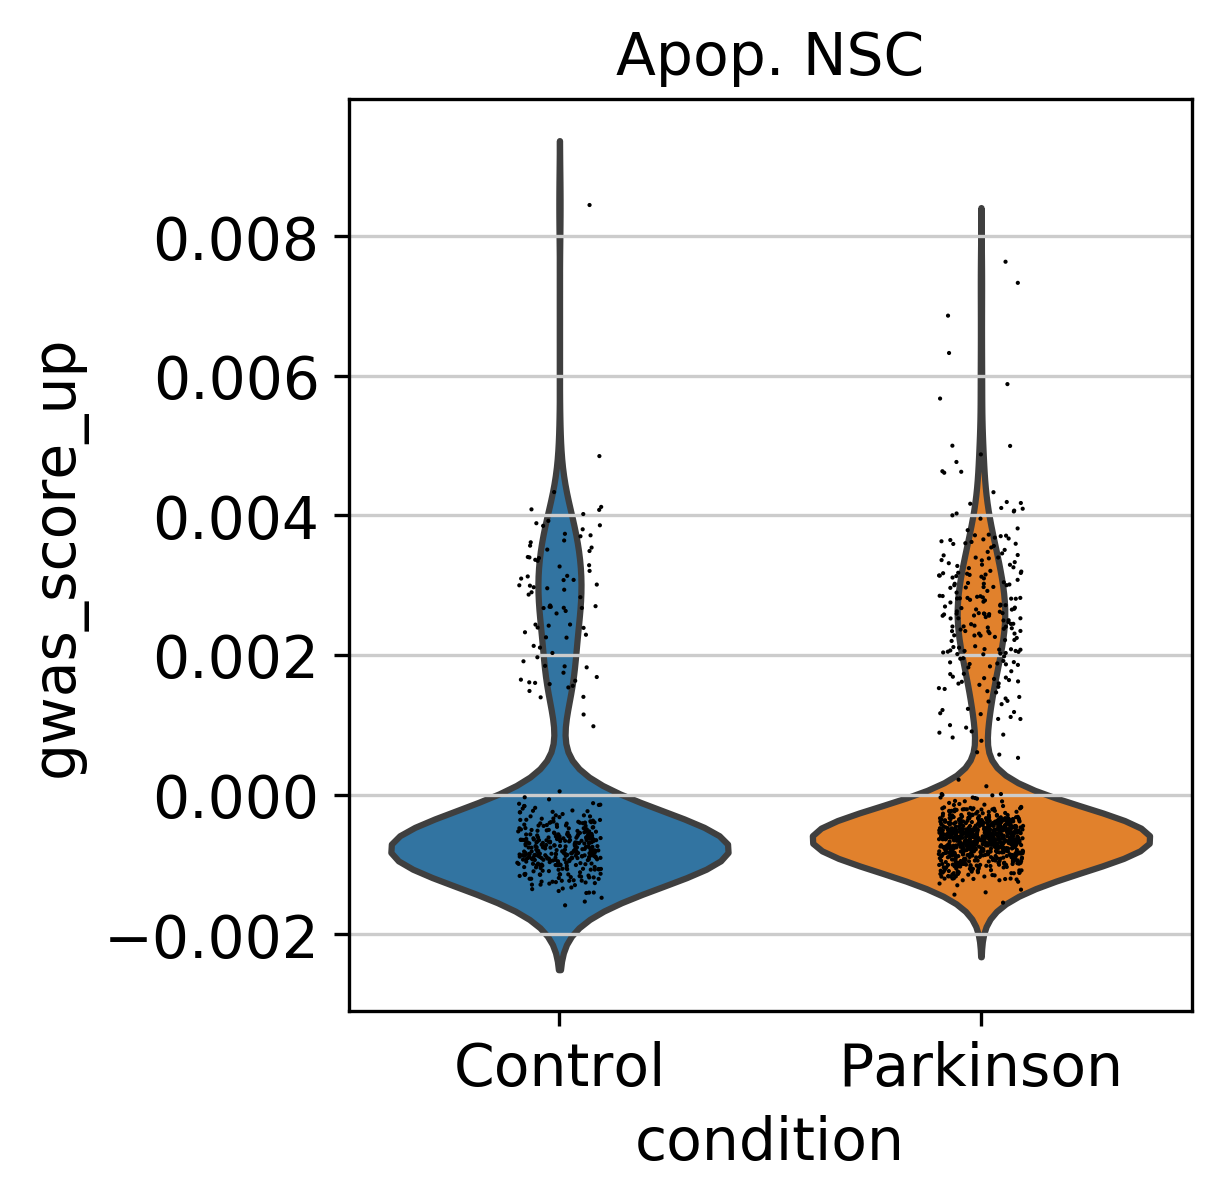

In [34]:
# Down-regulated genes
for clust in adata.obs['louvain_final'].cat.categories:
    ax = sc.pl.violin(adata[adata.obs.louvain_final.isin([clust])], 'gwas_score_up', groupby='condition', show=False)
    ax.set_title(clust)
    plt.show()

Text(0.5, 1.0, 'Glial prec. (myelinating)')

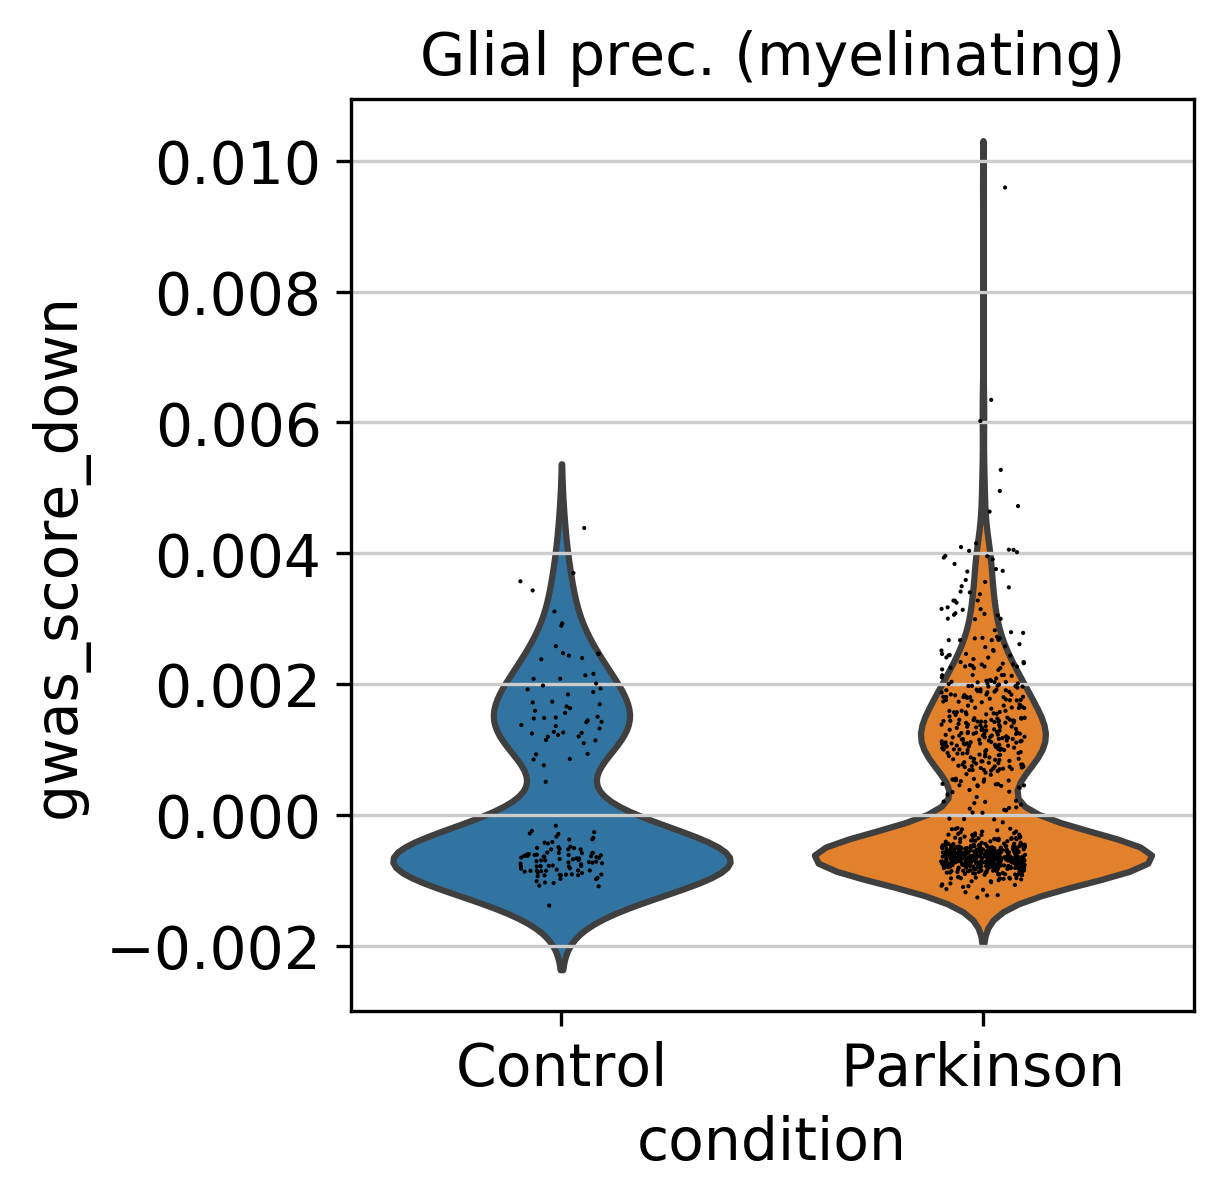

Text(0.5, 1.0, 'NCSC')

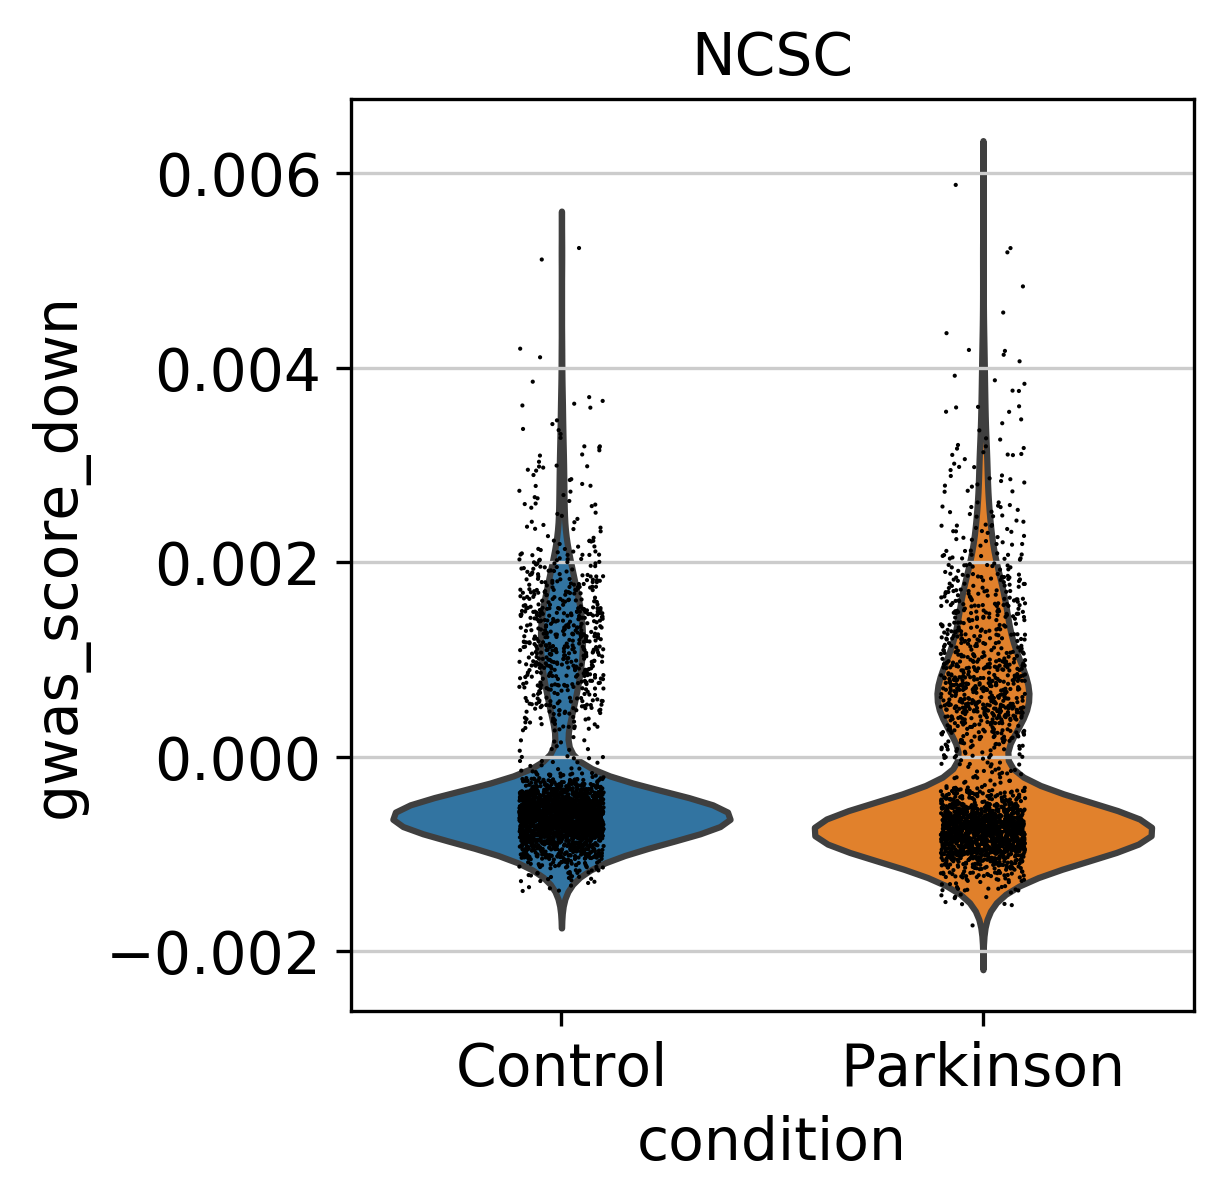

Text(0.5, 1.0, 'Apop. NCSC')

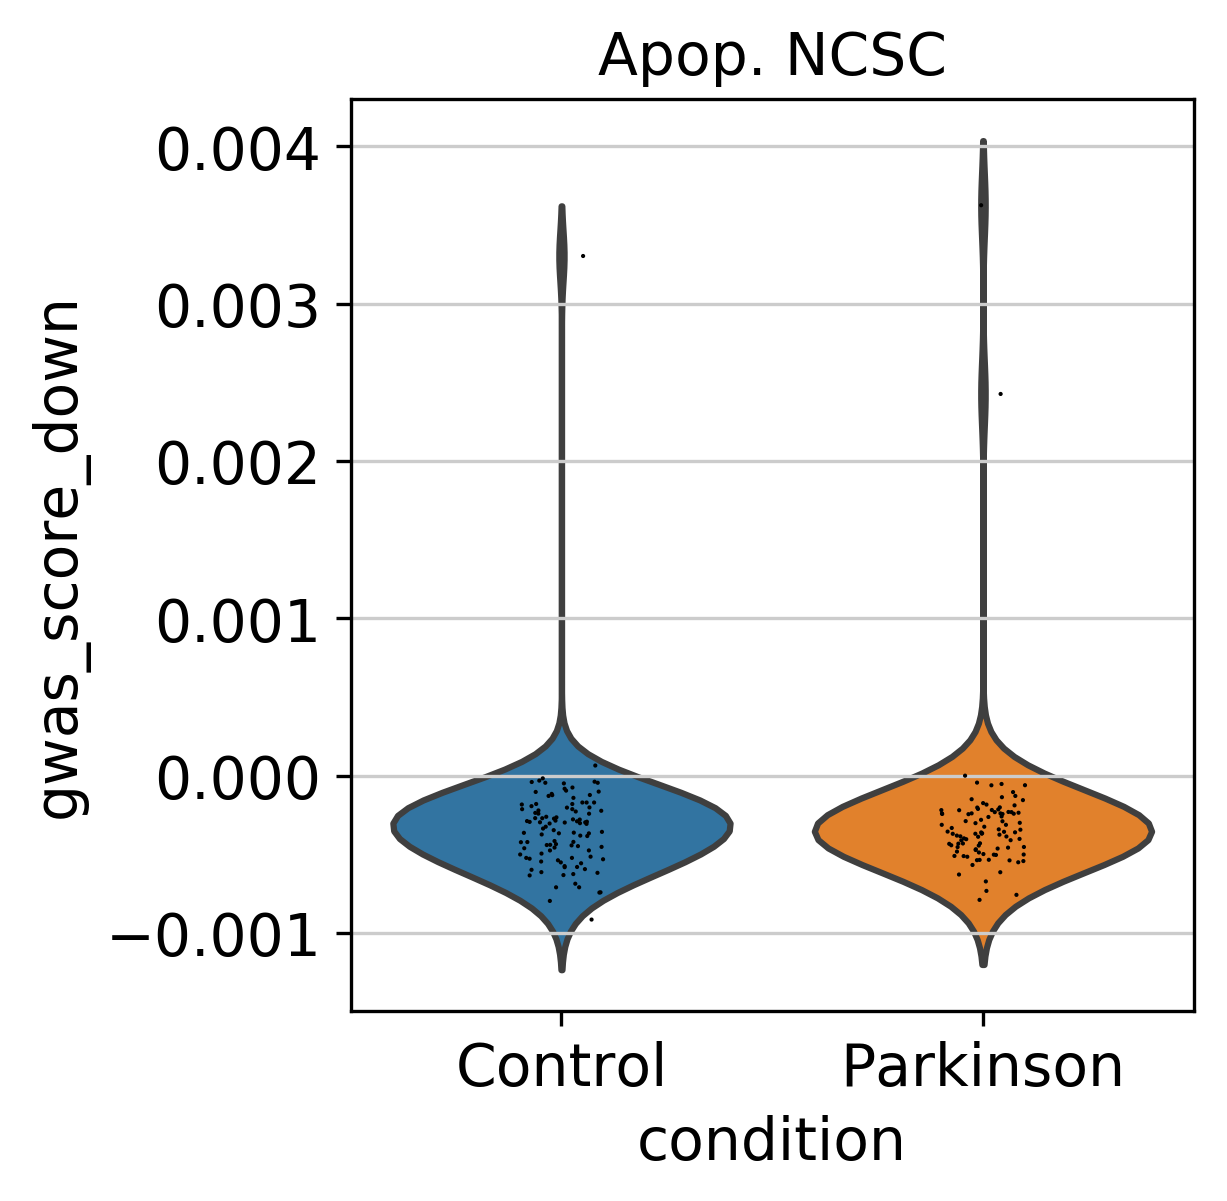

Text(0.5, 1.0, 'NSC2')

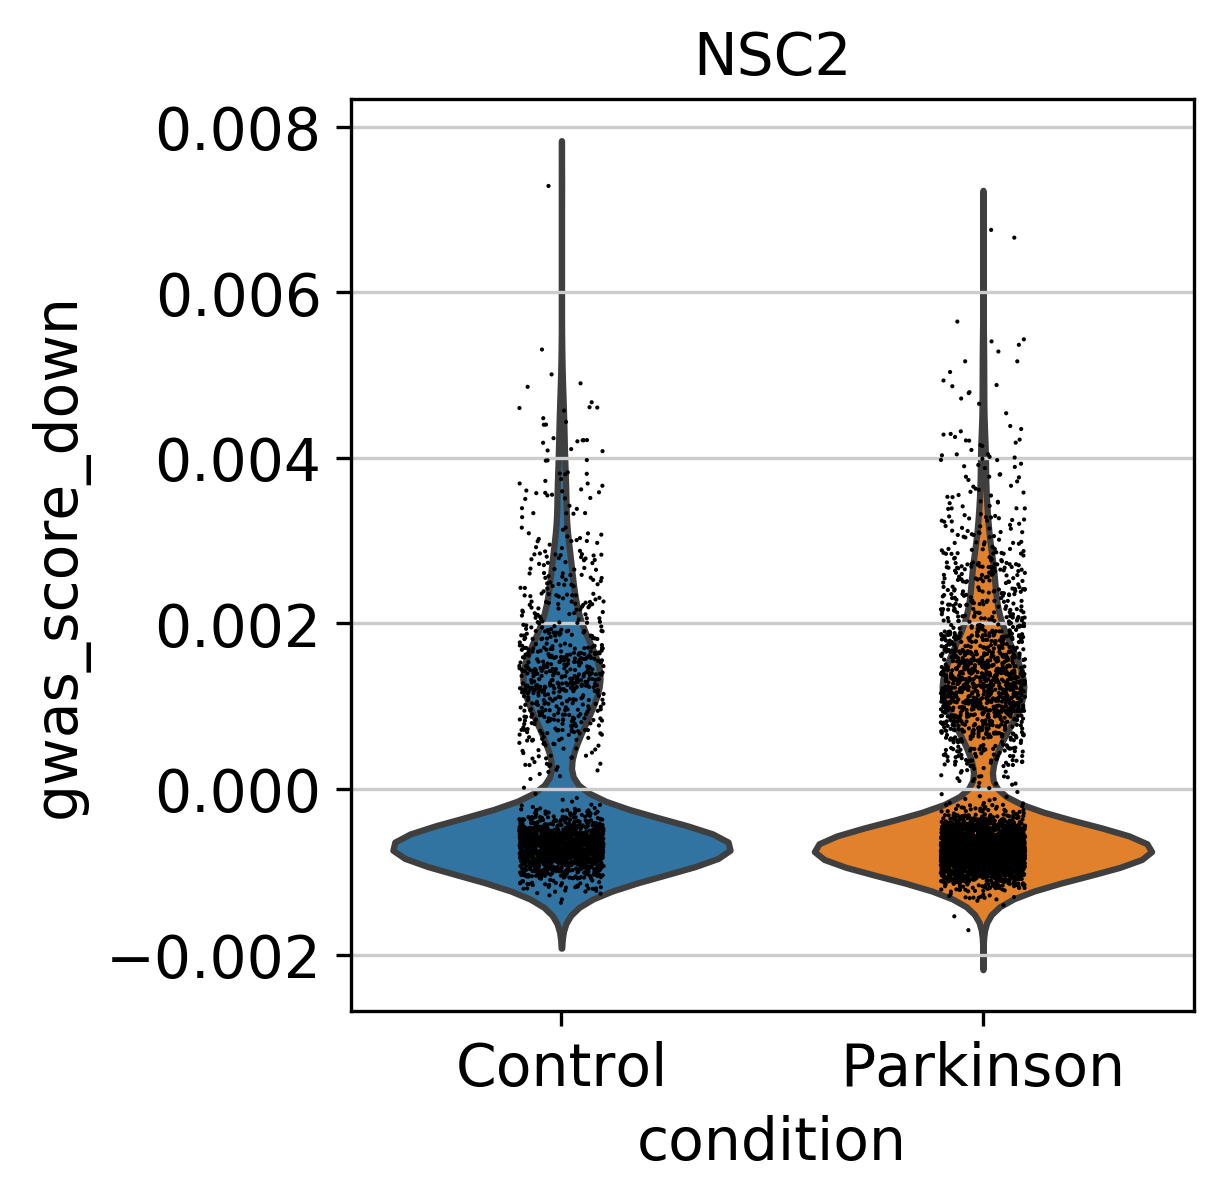

Text(0.5, 1.0, 'NSC2 (G2M)')

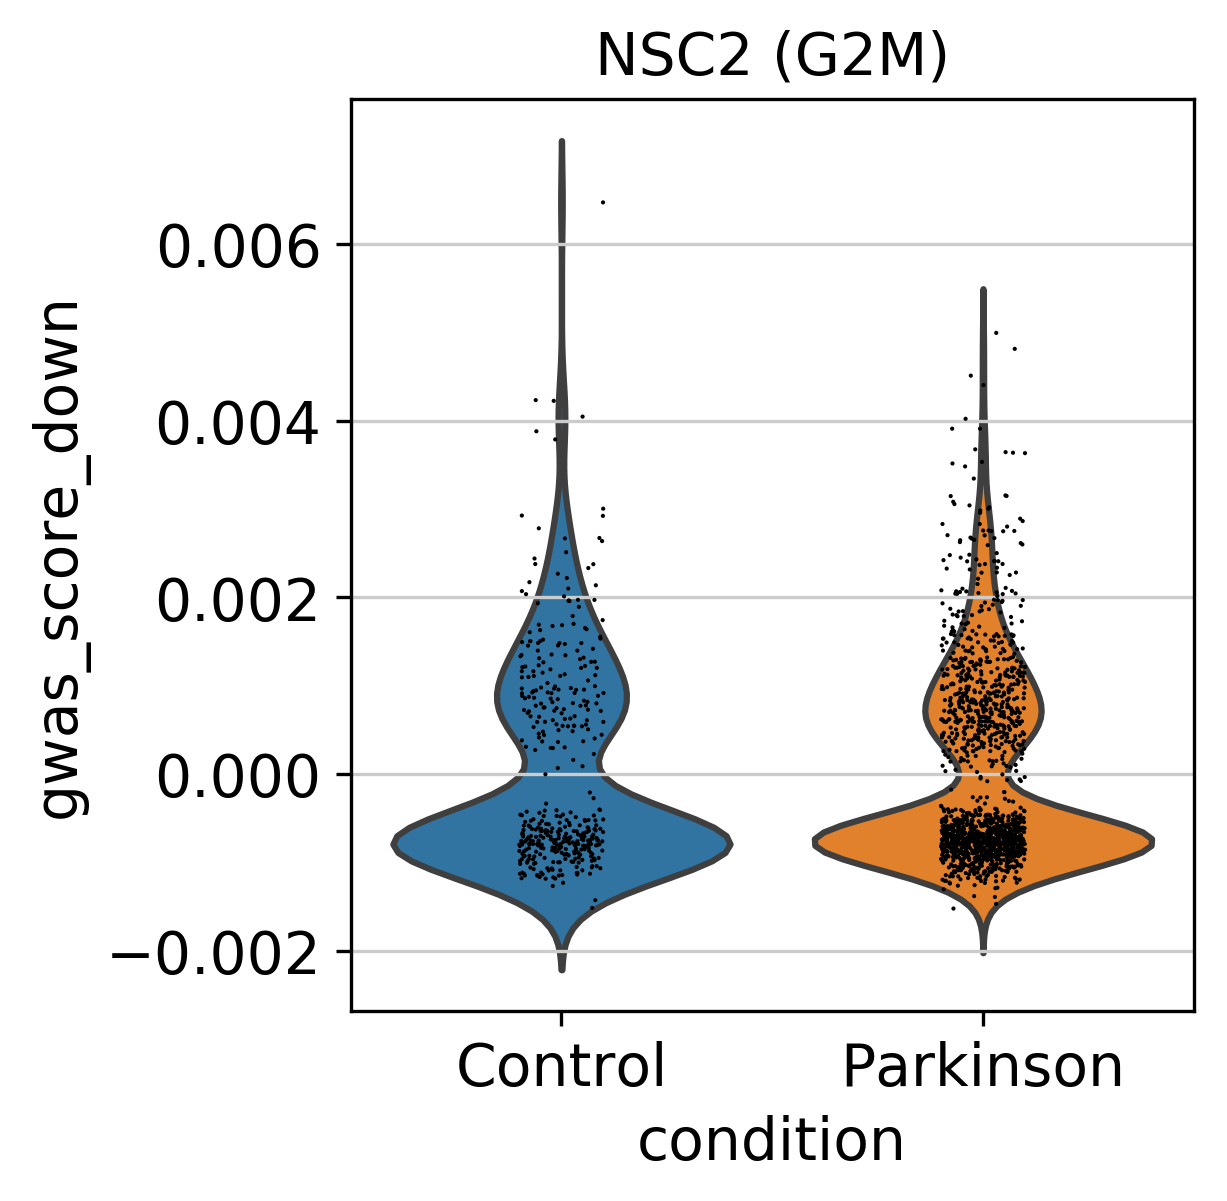

Text(0.5, 1.0, 'NSC1')

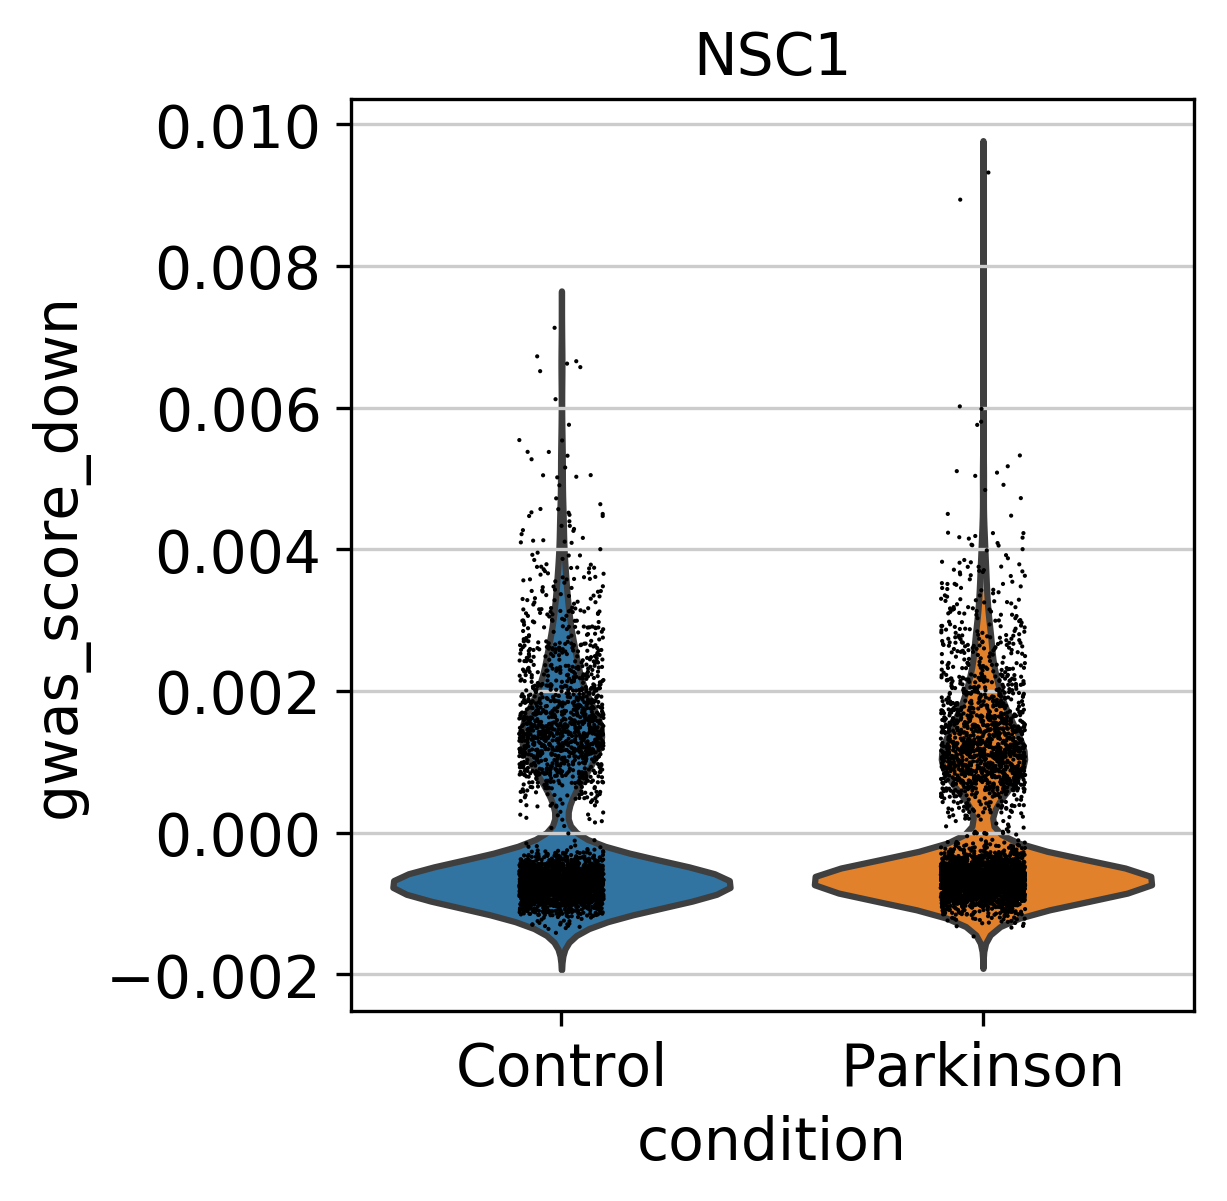

Text(0.5, 1.0, 'NSC1 (G2M)')

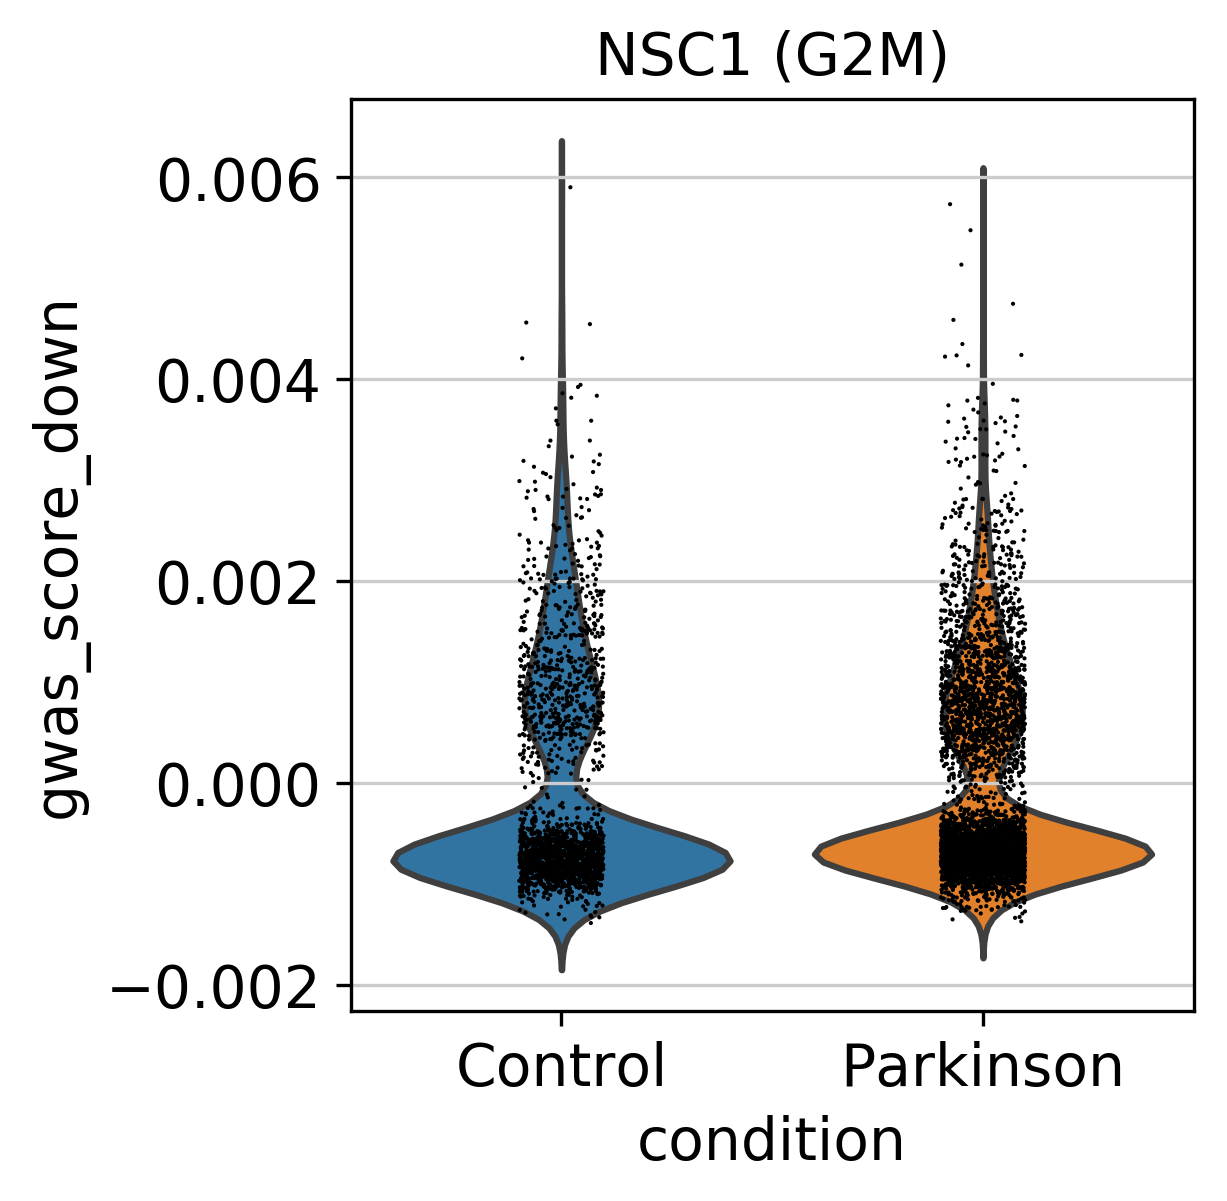

Text(0.5, 1.0, 'immature neurons')

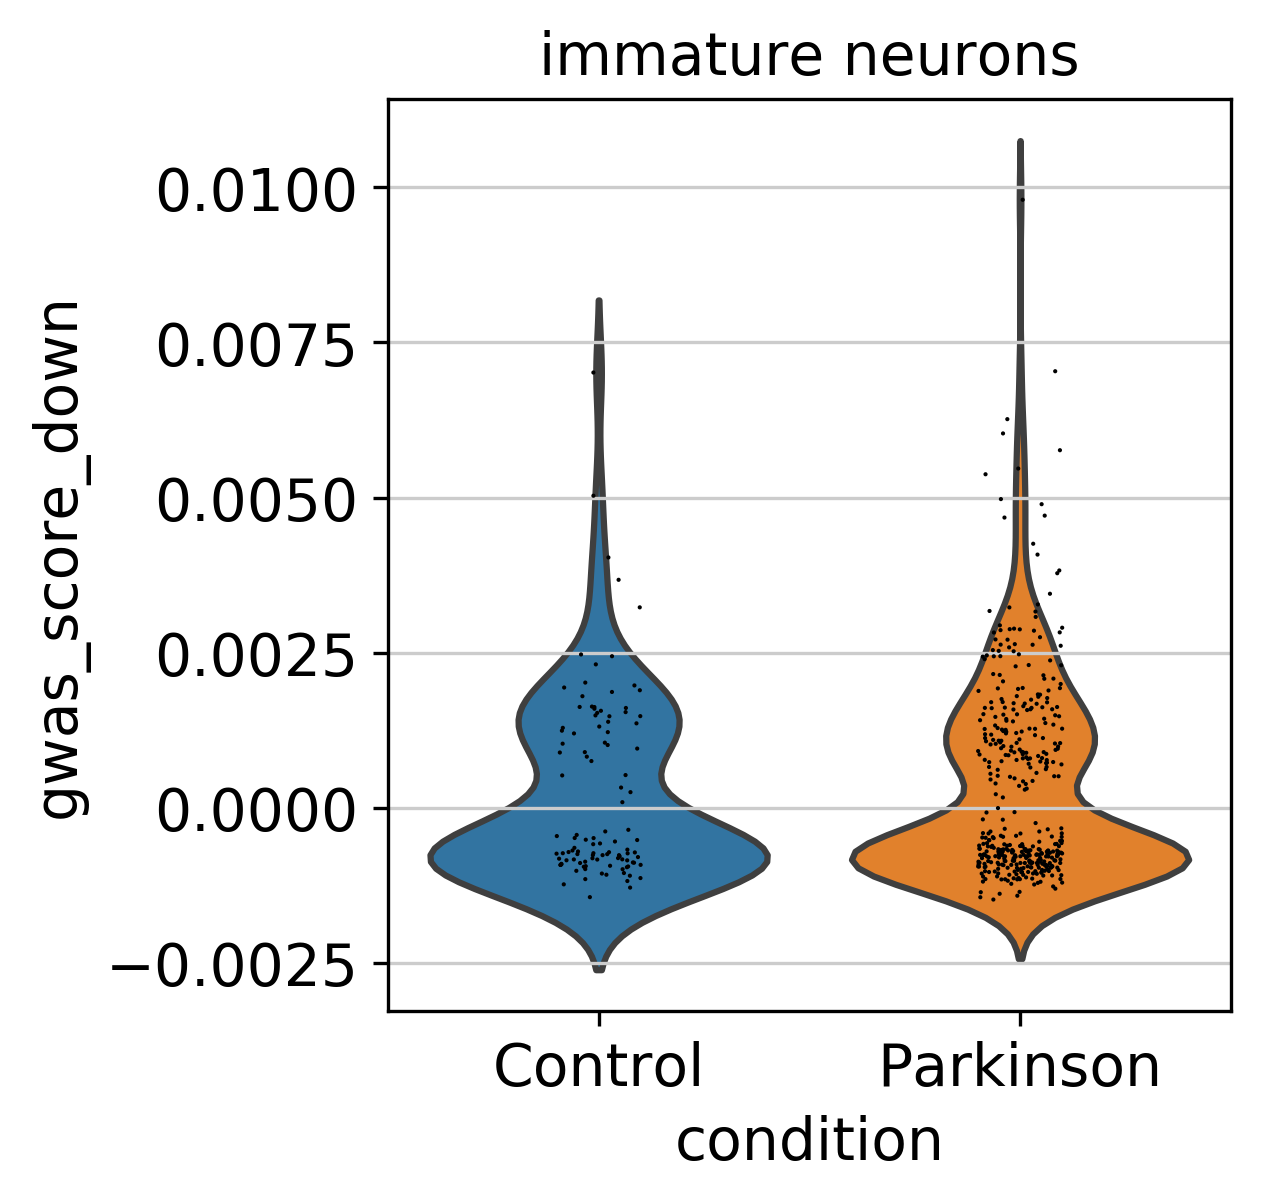

Text(0.5, 1.0, 'Apop. NSC')

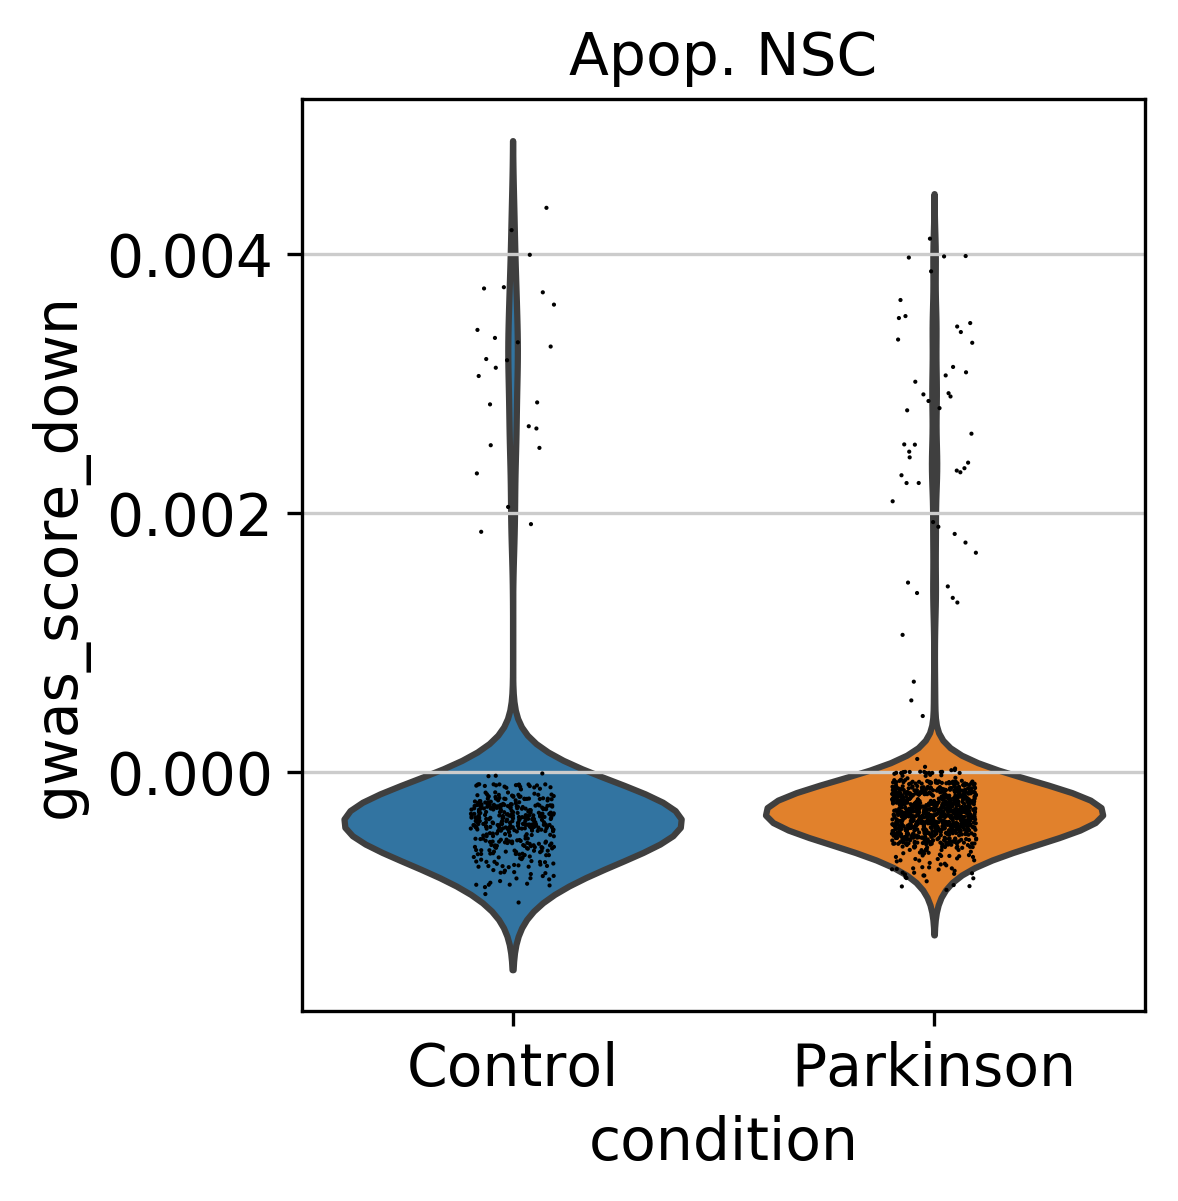

In [35]:
# Up-regulated genes
for clust in adata.obs['louvain_final'].cat.categories:
    ax = sc.pl.violin(adata[adata.obs.louvain_final.isin([clust])], 'gwas_score_down', groupby='condition', show=False)
    ax.set_title(clust)
    plt.show()

Text(0.5, 1.0, 'Glial prec. (myelinating)')

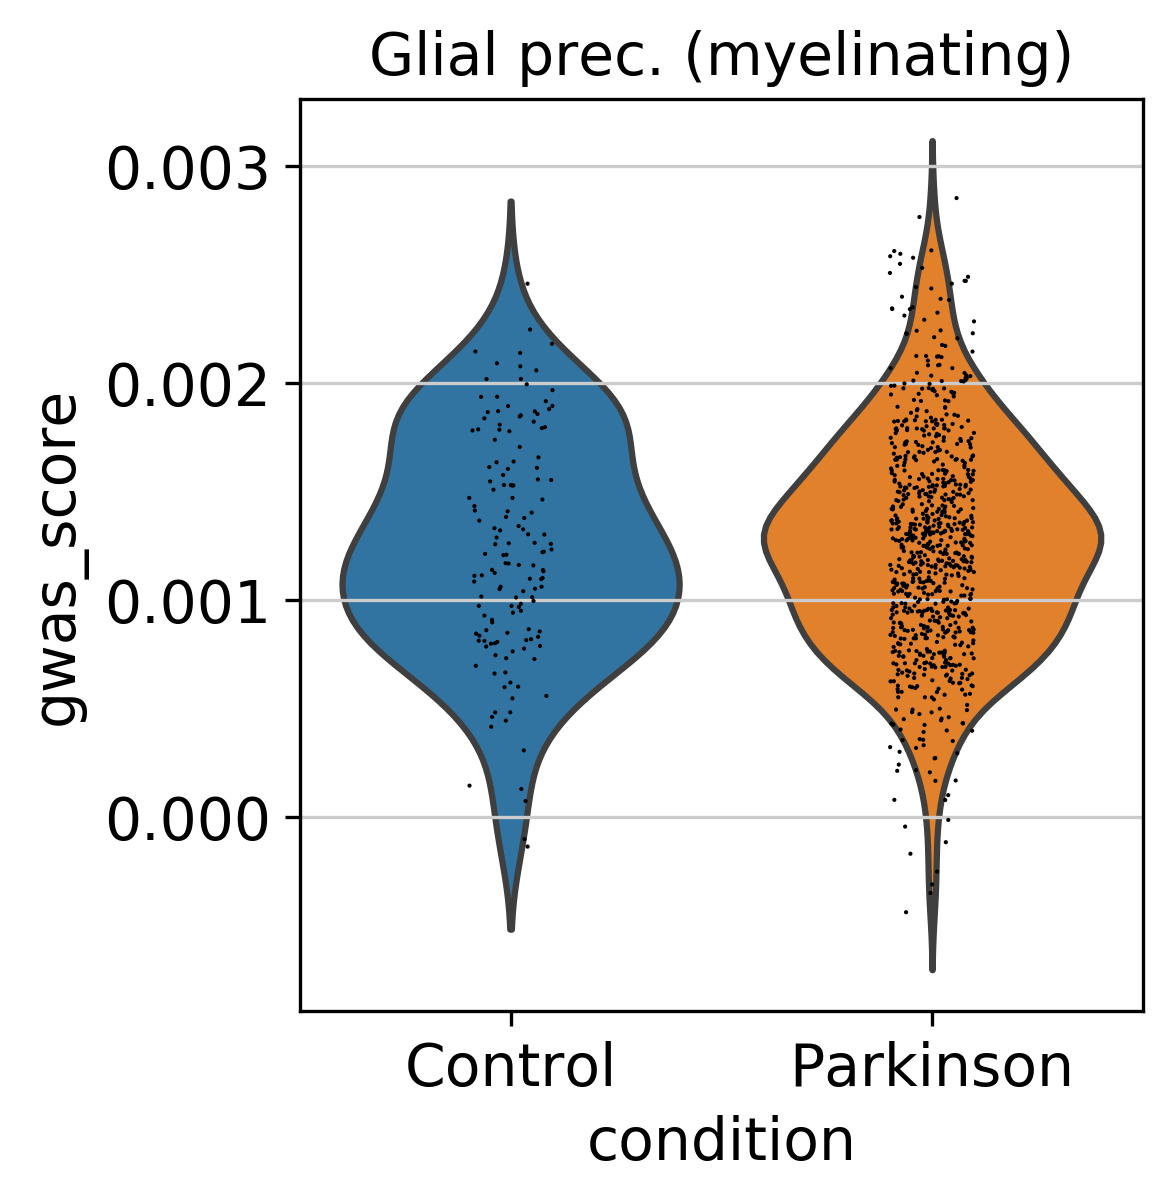

Text(0.5, 1.0, 'NCSC')

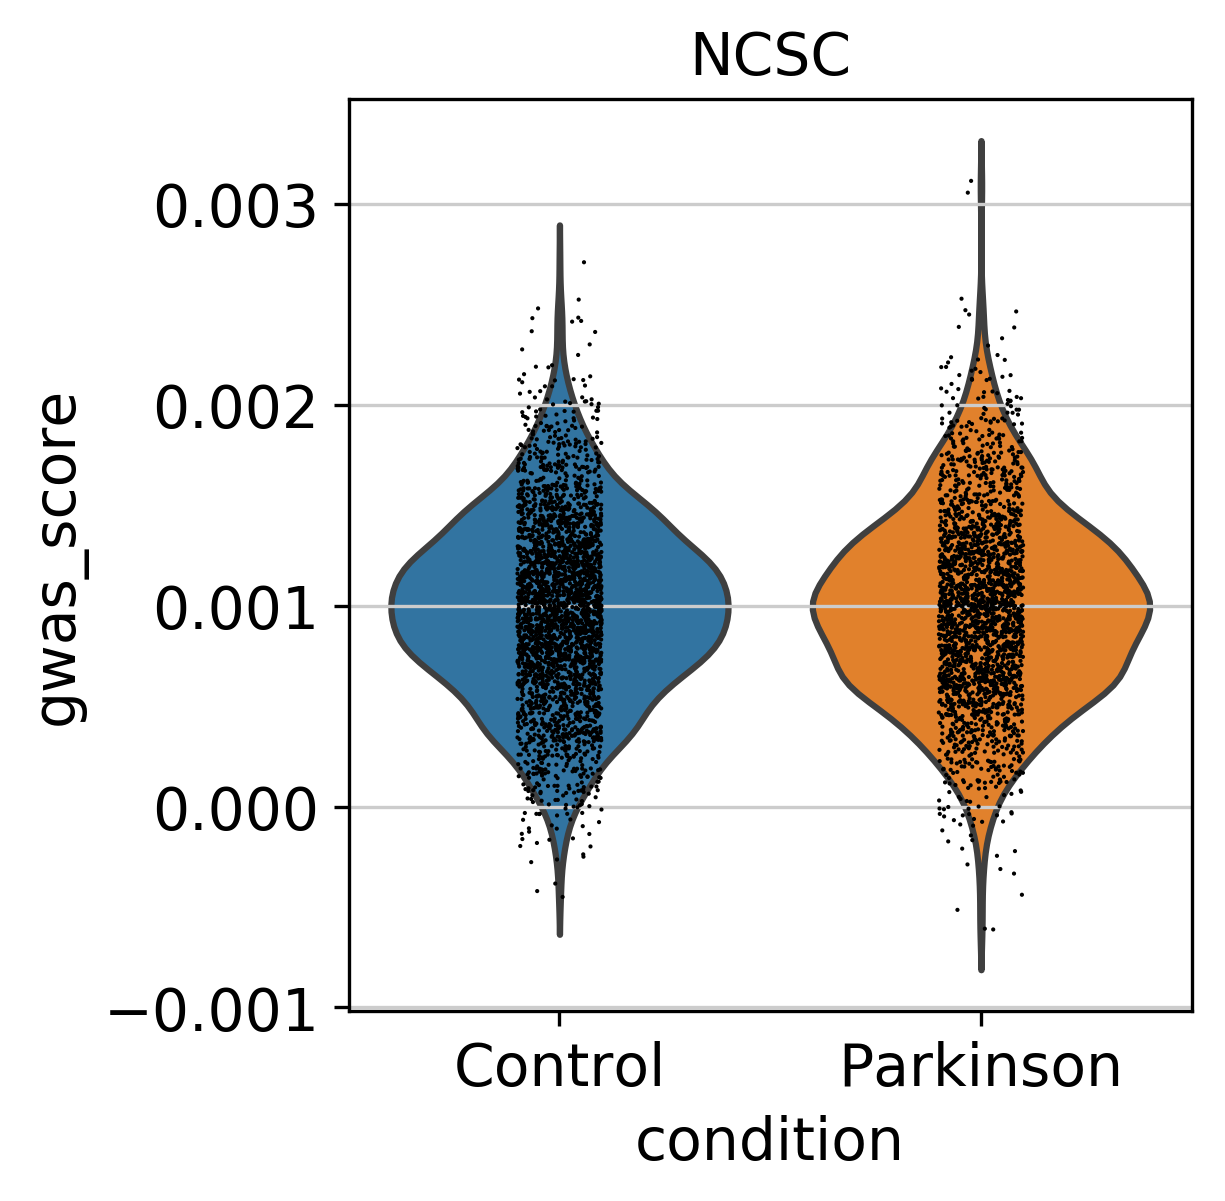

Text(0.5, 1.0, 'Apop. NCSC')

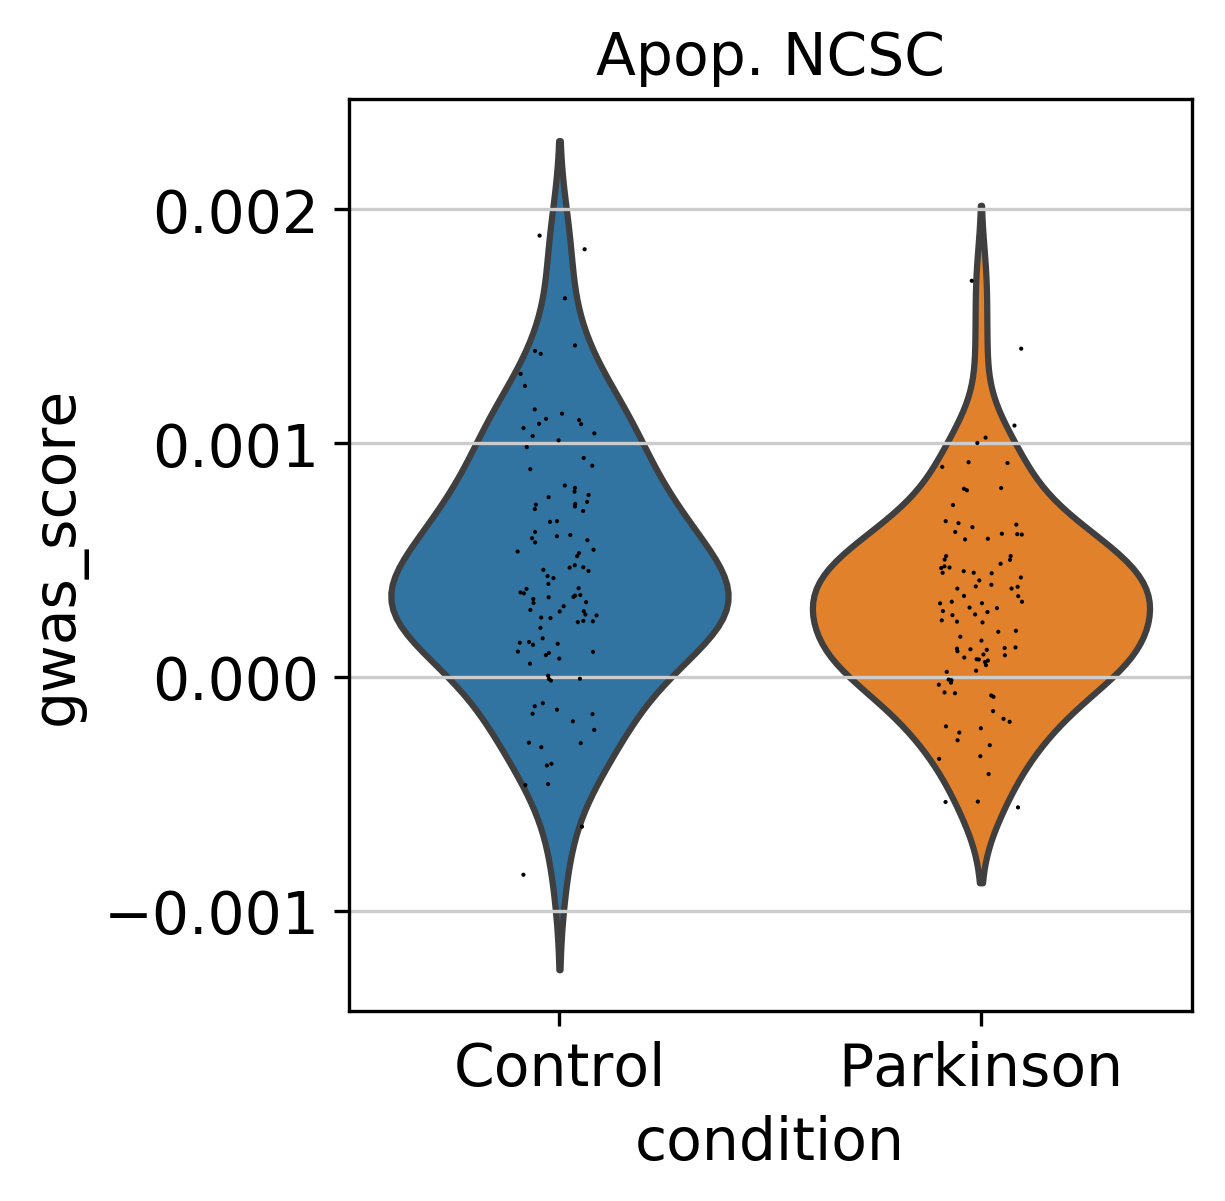

Text(0.5, 1.0, 'NSC2')

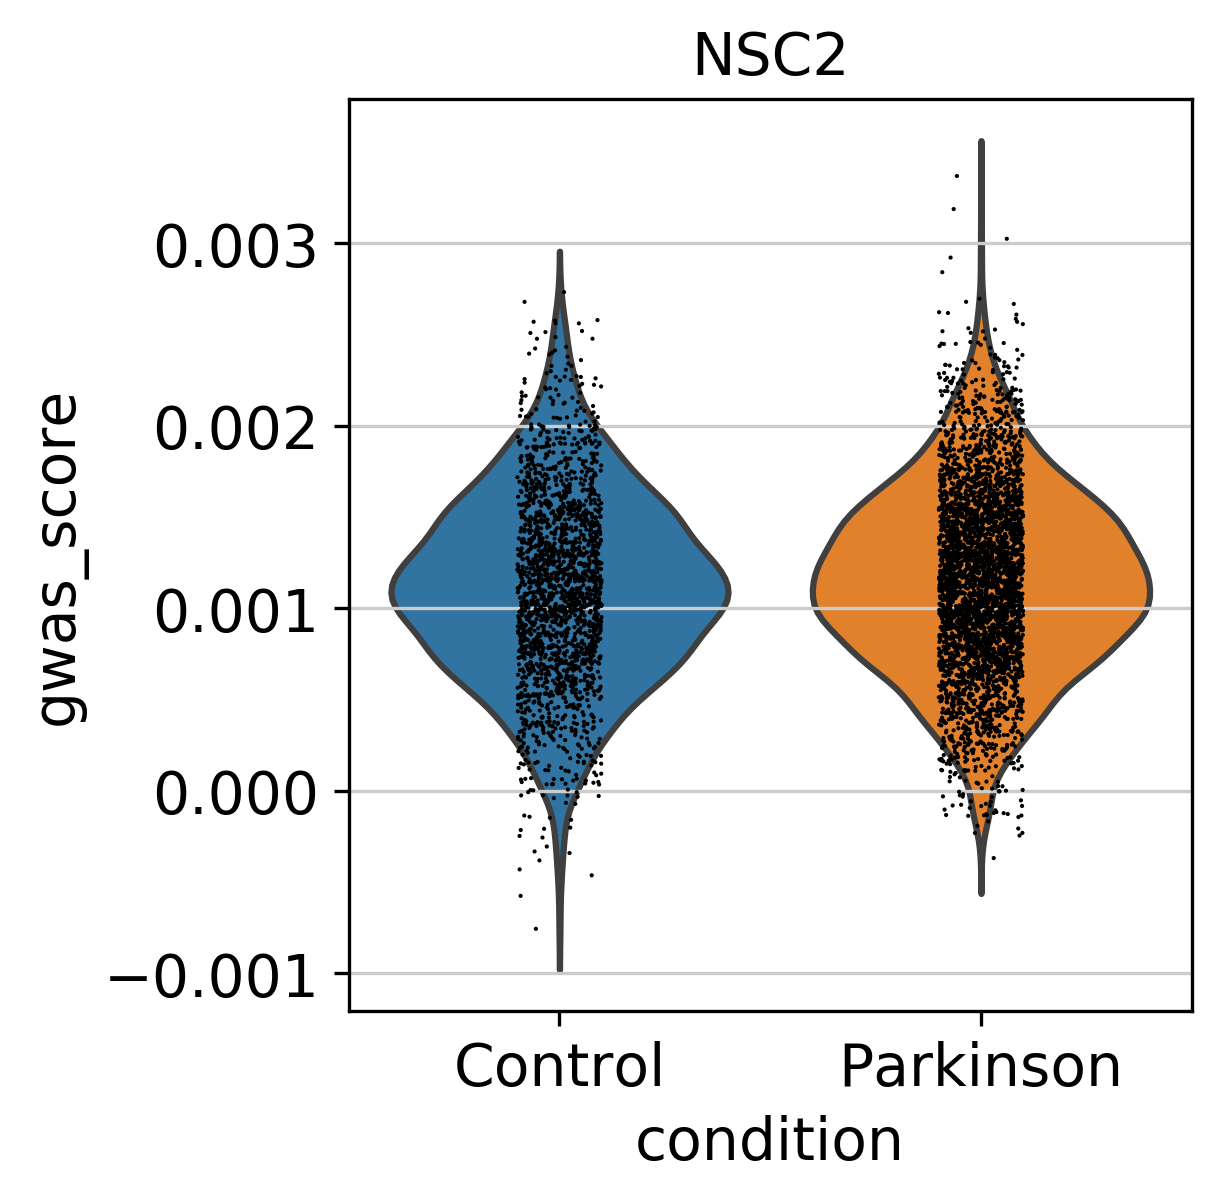

Text(0.5, 1.0, 'NSC2 (G2M)')

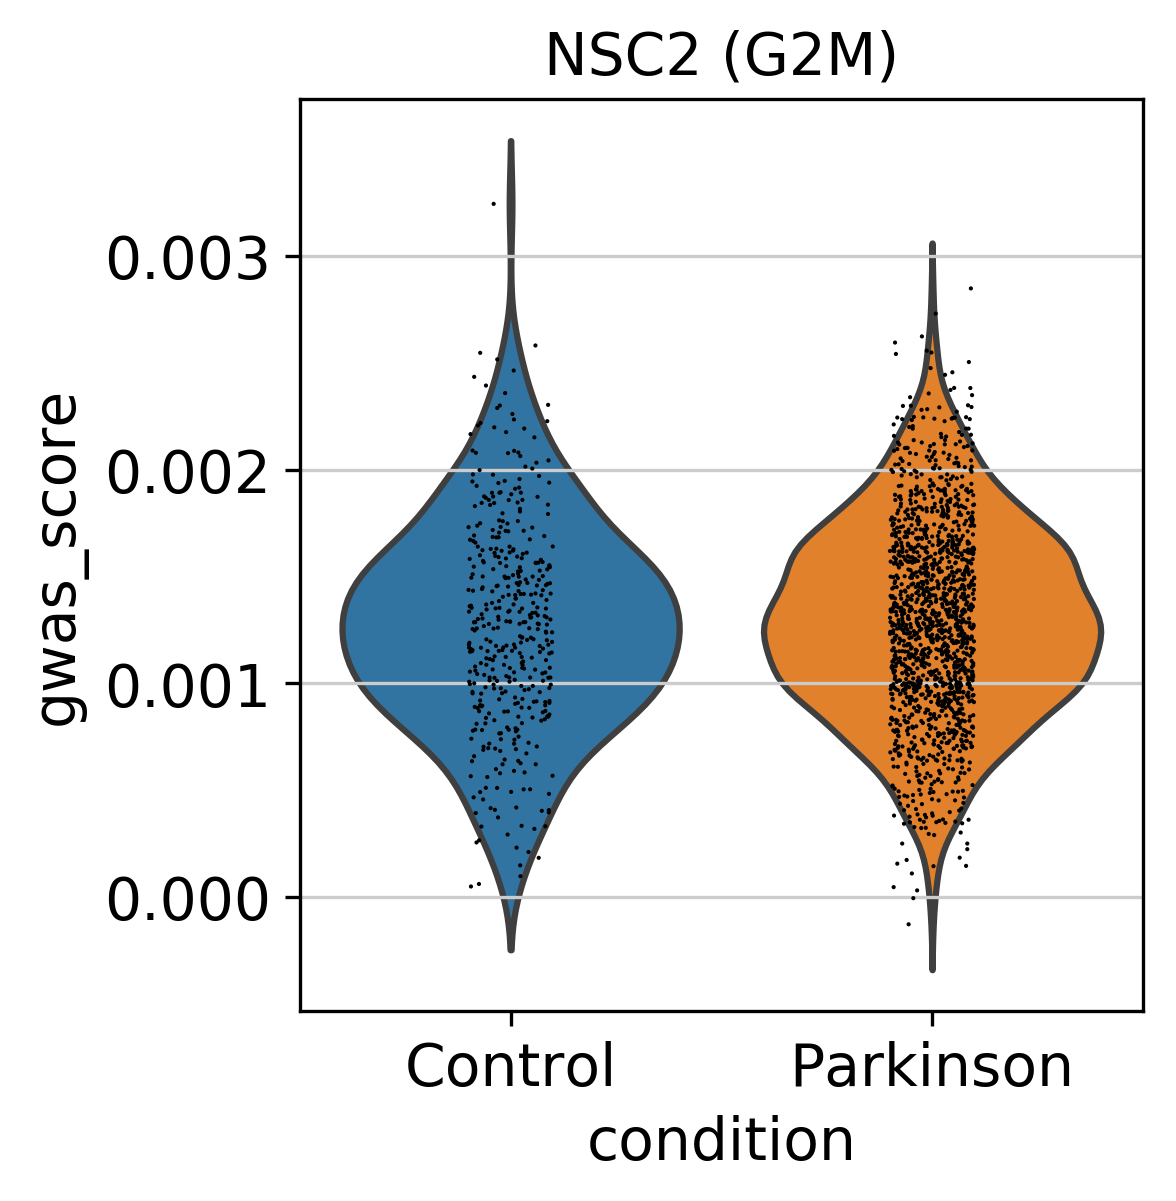

Text(0.5, 1.0, 'NSC1')

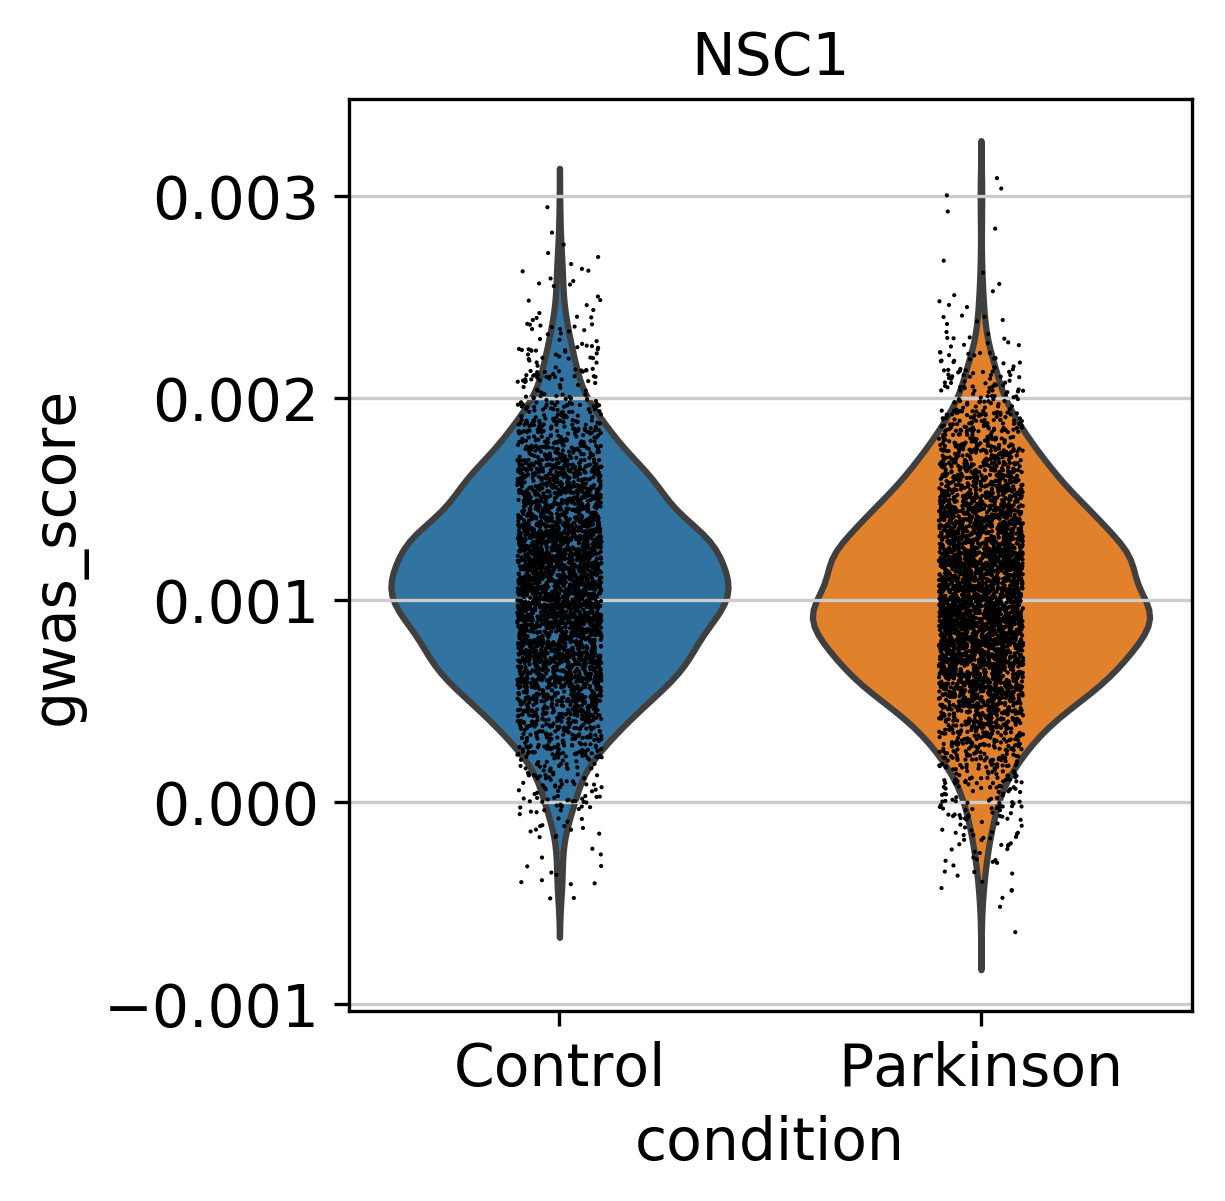

Text(0.5, 1.0, 'NSC1 (G2M)')

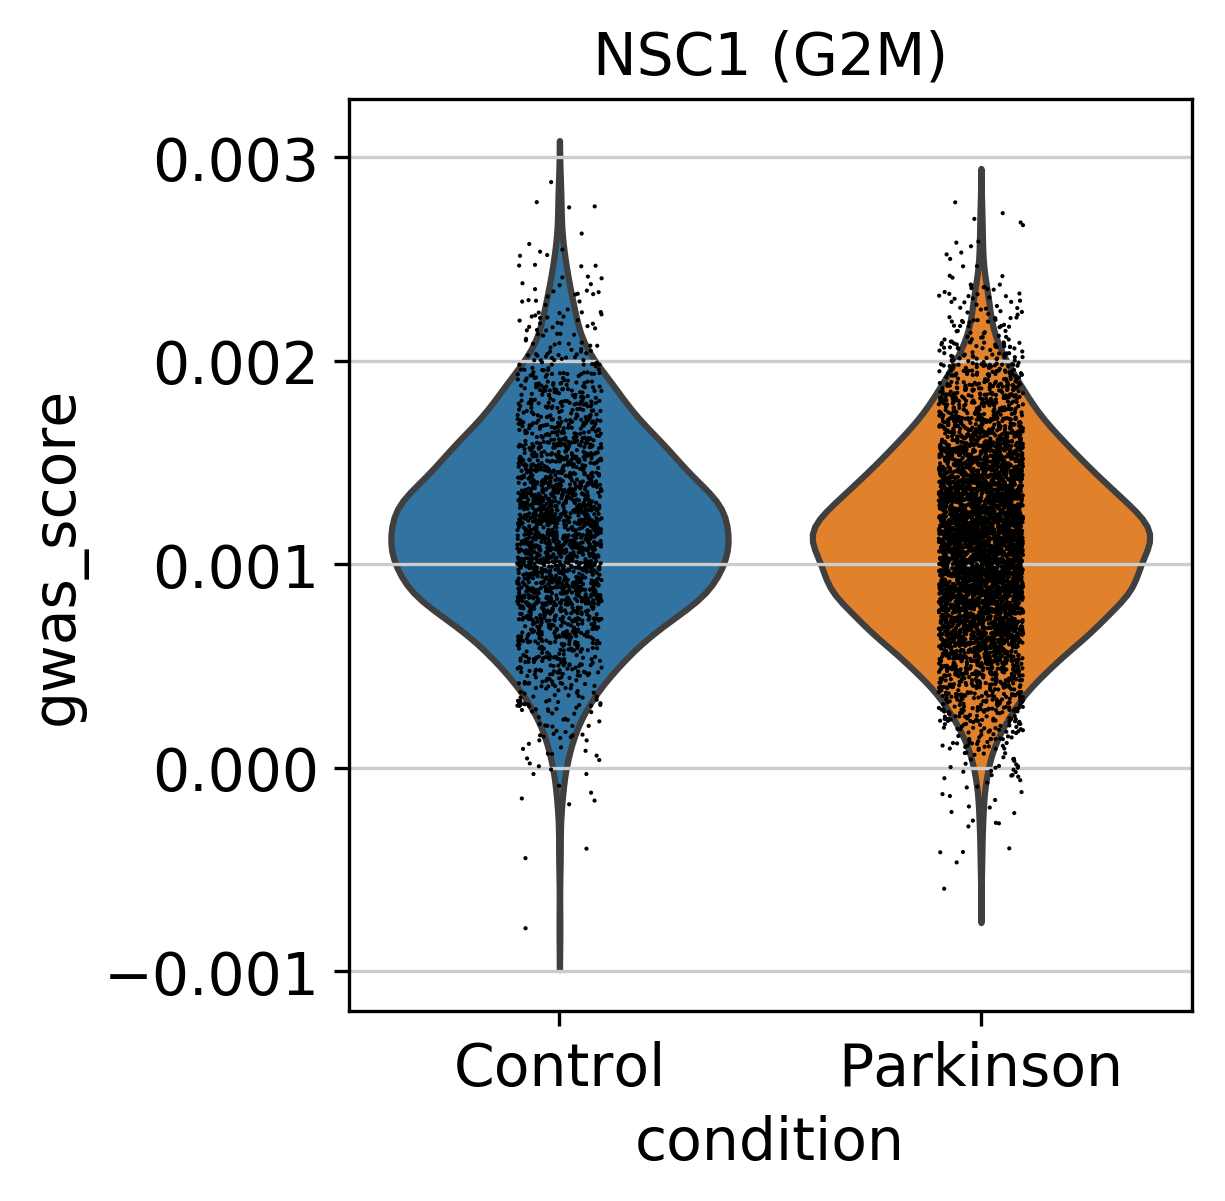

Text(0.5, 1.0, 'immature neurons')

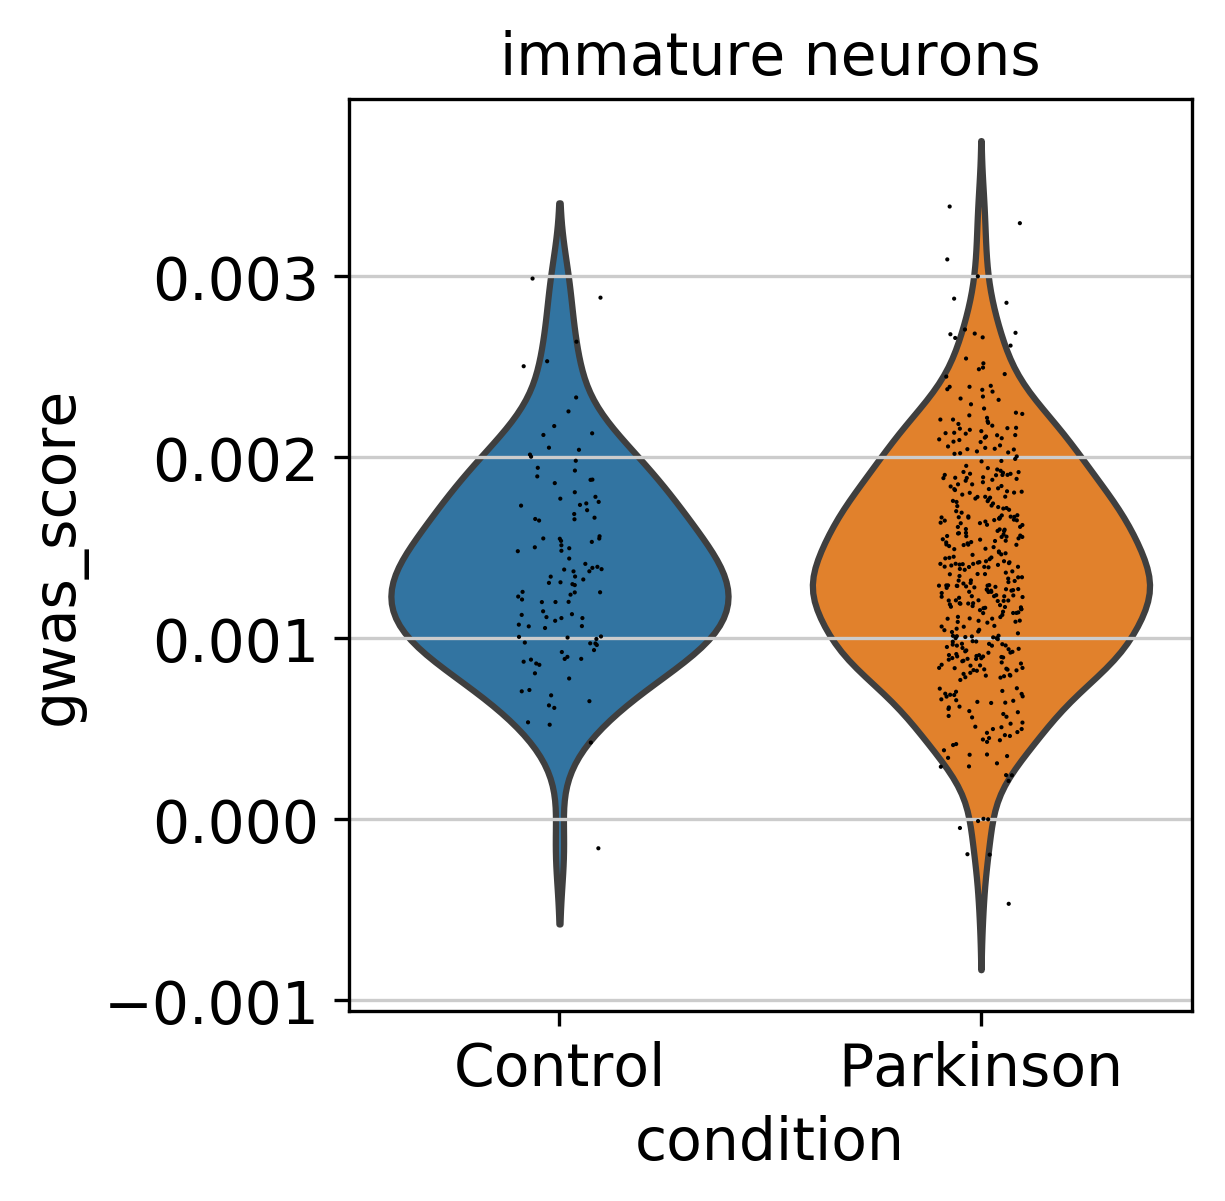

Text(0.5, 1.0, 'Apop. NSC')

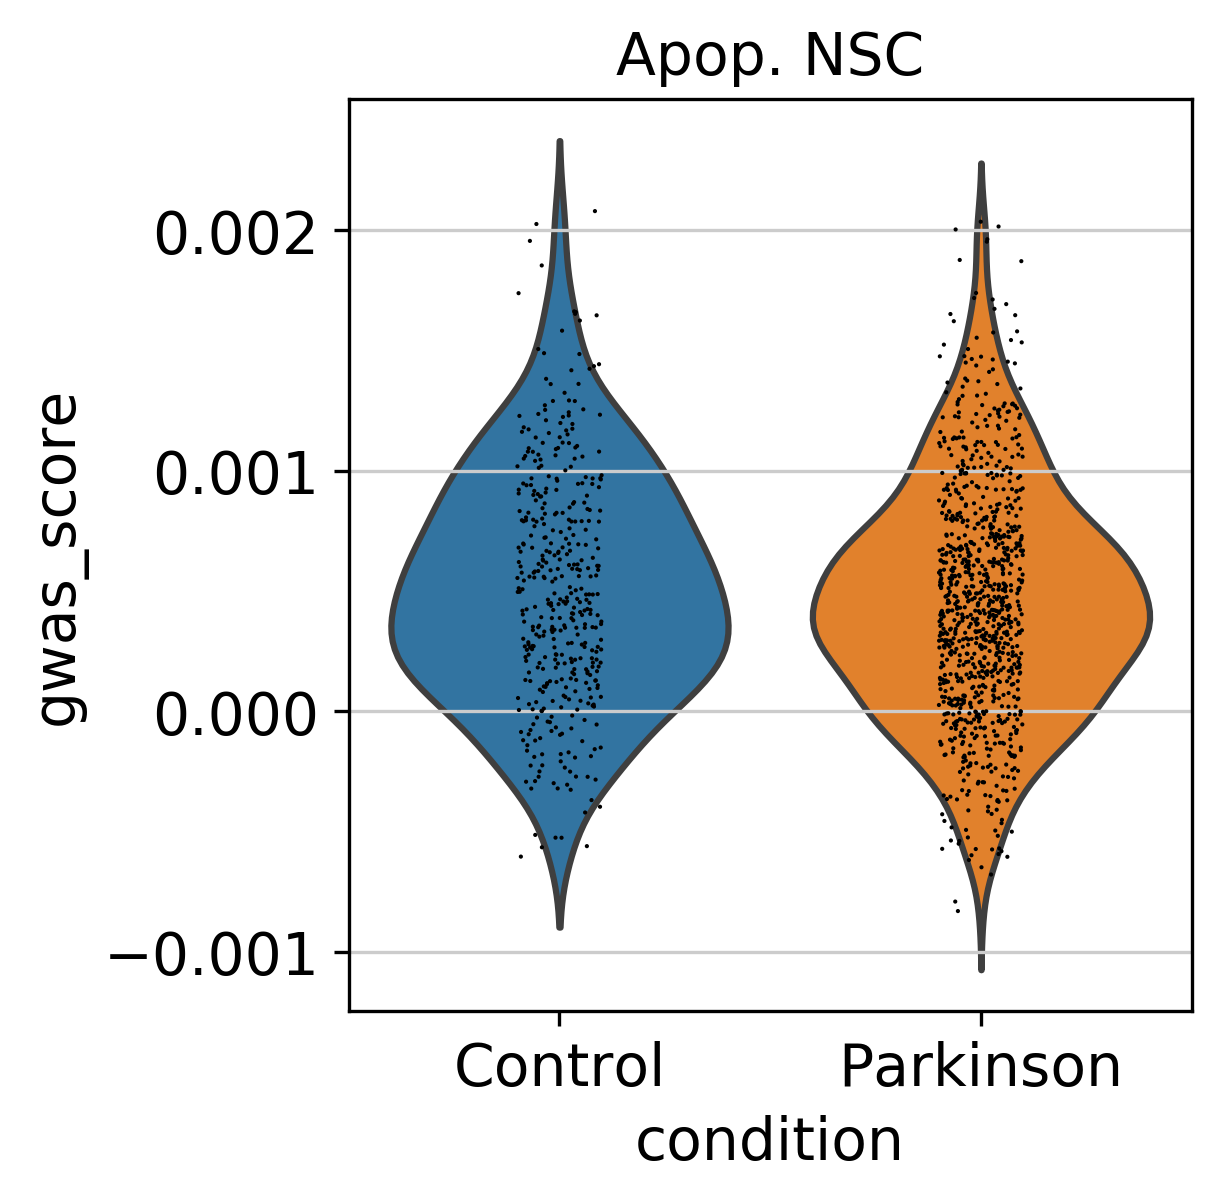

In [36]:
for clust in adata.obs['louvain_final'].cat.categories:
    ax = sc.pl.violin(adata[adata.obs.louvain_final.isin([clust])], 'gwas_score', groupby='condition', show=False)
    ax.set_title(clust)
    plt.show()

## Define wilcoxon test

In [15]:
def ranksum_adata(adata, obs, condition):
    from scipy.stats import ranksums

    cats = adata.obs[condition].cat.categories
    
    if len(cats) != 2:
        raise ValueError('please provide an obs column with two covariates')
        
    dat1 = adata[adata.obs[condition] == cats[0]].obs[obs]
    dat2 = adata[adata.obs[condition] == cats[1]].obs[obs]
    
    return ranksums(dat1, dat2)

In [16]:
from statsmodels.stats.multitest import multipletests

In [41]:
def ranksum_adata_clusters(adata, obs, condition, cluster_key, clusters='all', multiple_testing = 'fdr_bh'):
    from statsmodels.stats.multitest import multipletests
    import numpy as np

    mult_test_options = ['fdr_bh', 'bonferroni', 'holm-sidak', 'sidak', 'hs', None]

    if multiple_testing not in mult_test_options:
        raise ValueError(f'Please state a multiple testing correction method from'
                        '{*mult_test_options}.')

    # Test clusters argument
    if clusters != 'all' and not isinstance(clusters, list):
        raise ValueError('`clusters` should specify a list of clusters in `cluster_key` or `all`.')

    if clusters != 'all':
        clust_good = np.all([cl in adata.obs[cluster_key].cat.categories for cl in clusters])
    else:
        clust_good = True
        
    if not clust_good:
        raise ValueError('`clusters` should specify a list of clusters in `cluster_key` or `all`.')
        
    # Prep data object
    if clusters=='all':
        clusters = adata.obs[cluster_key].cat.categories

    test_df = pd.DataFrame(index=clusters, columns=['coef', 'p_value', 'adj_p_vals'])
        
    for clust in clusters:
        tmp = ranksum_adata(adata[adata.obs[cluster_key].isin([clust])], obs, condition)
        test_df['coef'][clust] = tmp[0]
        test_df['p_value'][clust] = tmp[1]
        
    if multiple_testing is not None:
        test_df['adj_p_vals'] = multipletests(list(test_df['p_value']), method=multiple_testing)[1]
    else:
        test_df = test_df.drop(columns='adj_p_vals')
    
    return test_df

In [42]:
ranksum_adata_clusters(adata, 'gwas_score_up', 'condition', 'louvain_final')

coef      p_value    adj_p_vals
Glial prec. (myelinating) -0.407059     0.683965  6.839645e-01
NCSC                      -0.551311      0.58142  6.540980e-01
Apop. NCSC                   5.2843  1.26184e-07  5.678298e-07
NSC2                        1.78076    0.0749517  1.349131e-01
NSC2 (G2M)                  1.11114     0.266509  3.997637e-01
NSC1                       -3.66388  0.000248426  7.452782e-04
NSC1 (G2M)                 0.744029     0.456859  5.873900e-01
immature neurons           -2.27489    0.0229123  5.155257e-02
Apop. NSC                   -5.6876  1.28837e-08  1.159536e-07

In [43]:
ranksum_adata_clusters(adata, 'gwas_score_down', 'condition', 'louvain_final')

coef      p_value    adj_p_vals
Glial prec. (myelinating)     -1.6238     0.104418  1.566272e-01
NCSC                          4.09378  4.24394e-05  1.273182e-04
Apop. NCSC                   0.261622     0.793613  8.928141e-01
NSC2                          1.75016    0.0800899  1.441618e-01
NSC2 (G2M)                -0.00494058     0.996058  9.960580e-01
NSC1                         -3.26436   0.00109713  2.468538e-03
NSC1 (G2M)                   -5.28708  1.24286e-07  5.592860e-07
immature neurons            -0.561474     0.574475  7.386102e-01
Apop. NSC                    -5.85225  4.84953e-09  4.364581e-08

# Further tests

Plans for further tests:
- use 'louvain_r0.2_noCC' for G2M-phase not separated out
- use 'root_cell_main' for NSC root

## No CC clusters

In [44]:
ranksum_adata_clusters(adata, 'gwas_score_up', 'condition', 'louvain_r0.2_noCC')
ranksum_adata_clusters(adata, 'gwas_score_down', 'condition', 'louvain_r0.2_noCC')

coef      p_value    adj_p_vals
Glial precursors (myelinating) -0.454169     0.649707  6.497073e-01
NCSC                           -0.805127     0.420747  4.908711e-01
NCSC (low MT)                     5.2843  1.26184e-07  4.416454e-07
NSC (Shh)                        3.16709   0.00153972  3.592682e-03
NSC (Wnt)                       -2.36423    0.0180674  3.161803e-02
immature neurons                -1.98891    0.0467107  6.539494e-02
late NPC                        -5.53302  3.14765e-08  2.203354e-07

coef      p_value    adj_p_vals
Glial precursors (myelinating)  -1.66296    0.0963207  1.348489e-01
NCSC                              4.0832  4.44205e-05  1.036479e-04
NCSC (low MT)                   0.261622     0.793613  7.936125e-01
NSC (Shh)                        3.04115   0.00235673  4.124284e-03
NSC (Wnt)                       -5.49942  3.81045e-08  1.333658e-07
immature neurons               -0.485262      0.62749  7.320722e-01
late NPC                        -5.79173   6.9664e-09  4.876483e-08

In [56]:
pd.crosstab(adata.obs['louvain_final'], adata.obs['louvain_r0.2_noCC'])

louvain_r0.2_noCC          Glial precursors (myelinating)  NCSC  \
louvain_final                                                     
Glial prec. (myelinating)                             969     0   
NCSC                                                    0  5009   
Apop. NCSC                                              0     0   
NSC2                                                    0     1   
NSC2 (G2M)                                              0     0   
NSC1                                                   33     3   
NSC1 (G2M)                                              0     0   
immature neurons                                        0    21   
Apop. NSC                                               0     0   

louvain_r0.2_noCC          NCSC (low MT)  NSC (Shh)  NSC (Wnt)  \
louvain_final                                                    
Glial prec. (myelinating)              0          0          2   
NCSC                                   0          0          1   
Apop. NCSC                           205          0          0   
NSC2                                   0       4744       1158   
NSC2 (G2M)                             0       1923          0   
NSC1                                   0        130       7438   
NSC1 (G2M)                             0          0       6980   
immature neurons                       0          0         29   
Apop. NSC                              0          5         14   

louvain_r0.2_noCC          immature neurons  late NPC  
louvain_final                                          
Glial prec. (myelinating)                 0         2  
NCSC                                      0         2  
Apop. NCSC                                0         0  
NSC2                                      0        11  
NSC2 (G2M)                                0         0  
NSC1                                      0        26  
NSC1 (G2M)                                0         0  
immature neurons                        477         5  
Apop. NSC                                 0      1369

## Root cells

To test root cell clusters:
1. Transfer gwas scores to velo object
2. Test on velo object (reduced number of cells)

In [46]:
adata_velo.obs_names[:10]
adata.obs_names[:10]

Index(['WHHHW:AAACCTGTCTTGTACT', 'WHHHW:AAACGGGTCGTTACAG',
       'WHHHW:AAAGATGCAAGCCCAC', 'WHHHW:AAAGATGCAATCGGTT',
       'WHHHW:AAAGCAAAGAGTCGGT', 'WHHHW:AAAGTAGGTTAAAGTG',
       'WHHHW:AAATGCCAGGATTCGG', 'WHHHW:AAATGCCTCGTGGTCG',
       'WHHHW:AAATGCCTCTGTGCAA', 'WHHHW:AACCGCGAGGTTACCT'],
      dtype='object')

Index(['AAACCTGTCTTGTACT-0', 'AAACGGGTCGTTACAG-0', 'AAAGATGCAAGCCCAC-0',
       'AAAGATGCAATCGGTT-0', 'AAAGCAAAGAGTCGGT-0', 'AAAGTAGGTTAAAGTG-0',
       'AAATGCCAGGATTCGG-0', 'AAATGCCTCGTGGTCG-0', 'AAATGCCTCTGTGCAA-0',
       'AACCGCGAGGTTACCT-0'],
      dtype='object', name='index')

In [47]:
# Map obs_names formats
velo_red_obsn = [idx.split(':')[1] for idx in adata_velo.obs_names]
ad_red_obsn = [idx.split('-')[0] for idx in adata.obs_names]

In [50]:
# Sanity checks
len(velo_red_obsn) == len(np.unique(velo_red_obsn))
len(ad_red_obsn) == len(np.unique(ad_red_obsn))
set(velo_red_obsn).difference(ad_red_obsn)

True

True

set()

In [51]:
adata.obs_names = ad_red_obsn
adata_velo.obs_names = velo_red_obsn

In [52]:
adata_velo.obs['gwas_score_up'] = adata[adata_velo.obs_names].obs['gwas_score_up']
adata_velo.obs['gwas_score_down'] = adata[adata_velo.obs_names].obs['gwas_score_down']

In [54]:
ranksum_adata_clusters(adata_velo, 'gwas_score_up', 'condition', 'root_cell_main', clusters=['True'])
ranksum_adata_clusters(adata_velo, 'gwas_score_down', 'condition', 'root_cell_main', clusters=['True'])

KeyError: 'root_cell_main'

# Check test statistic directions

## NSC1 

### GWAS score down

In [137]:
# Test NSC1:
cluster_key = 'louvain_final'
clust = 'NSC1'
condition = 'condition'
obs = 'gwas_score_down'
cats = adata.obs[condition].cat.categories
adata_sub = adata[adata.obs[cluster_key].isin([clust])]
dat1 = adata_sub[adata_sub.obs[condition] == cats[0]].obs[obs]
dat2 = adata_sub[adata_sub.obs[condition] == cats[1]].obs[obs]

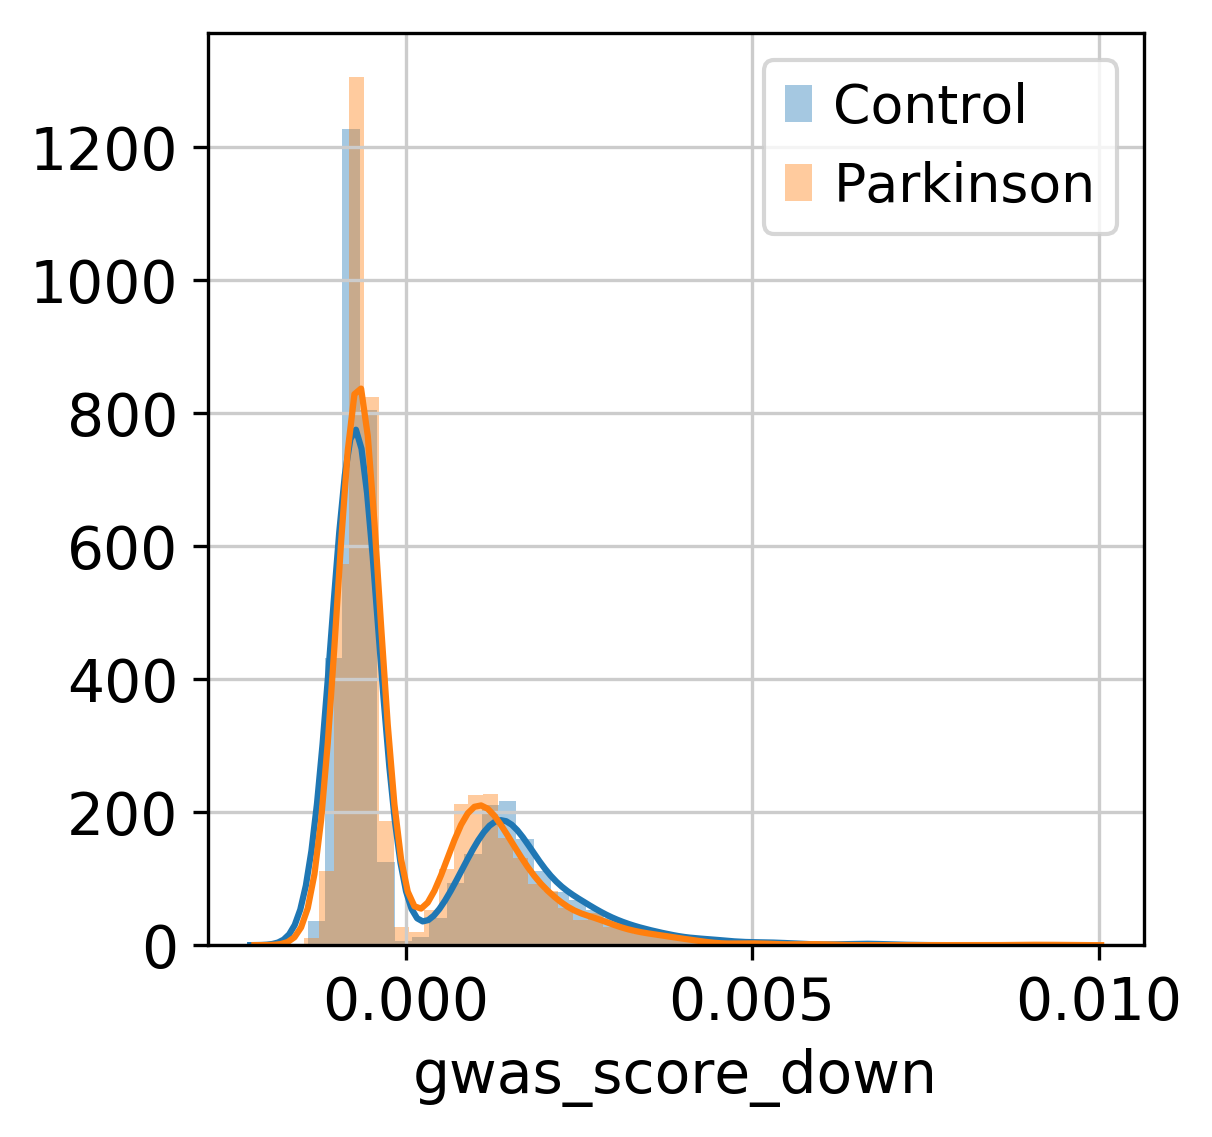

In [138]:
sb.distplot(dat1)
sb.distplot(dat2)
plt.legend(cats)

In [139]:
df = pd.DataFrame(index=adata_sub.obs_names)
df['values'] = adata_sub.obs[obs]
df['condition'] = adata_sub.obs['condition']
df['ranks'] = df['values'].rank()

In [140]:
df.groupby('condition')['values'].mean()

condition
Control      0.000126
Parkinson    0.000075
Name: values, dtype: float32

In [141]:
df.groupby('condition')['values'].median()

condition
Control     -0.000590
Parkinson   -0.000546
Name: values, dtype: float32

In [142]:
df.groupby('condition')['ranks'].mean()

condition
Control      3727.343134
Parkinson    3892.366904
Name: ranks, dtype: float64

### GWAS score up

In [143]:
# Test NSC1:
cluster_key = 'louvain_final'
clust = 'NSC1'
condition = 'condition'
obs = 'gwas_score_up'
cats = adata.obs[condition].cat.categories
adata_sub = adata[adata.obs[cluster_key].isin([clust])]
dat1 = adata_sub[adata_sub.obs[condition] == cats[0]].obs[obs]
dat2 = adata_sub[adata_sub.obs[condition] == cats[1]].obs[obs]

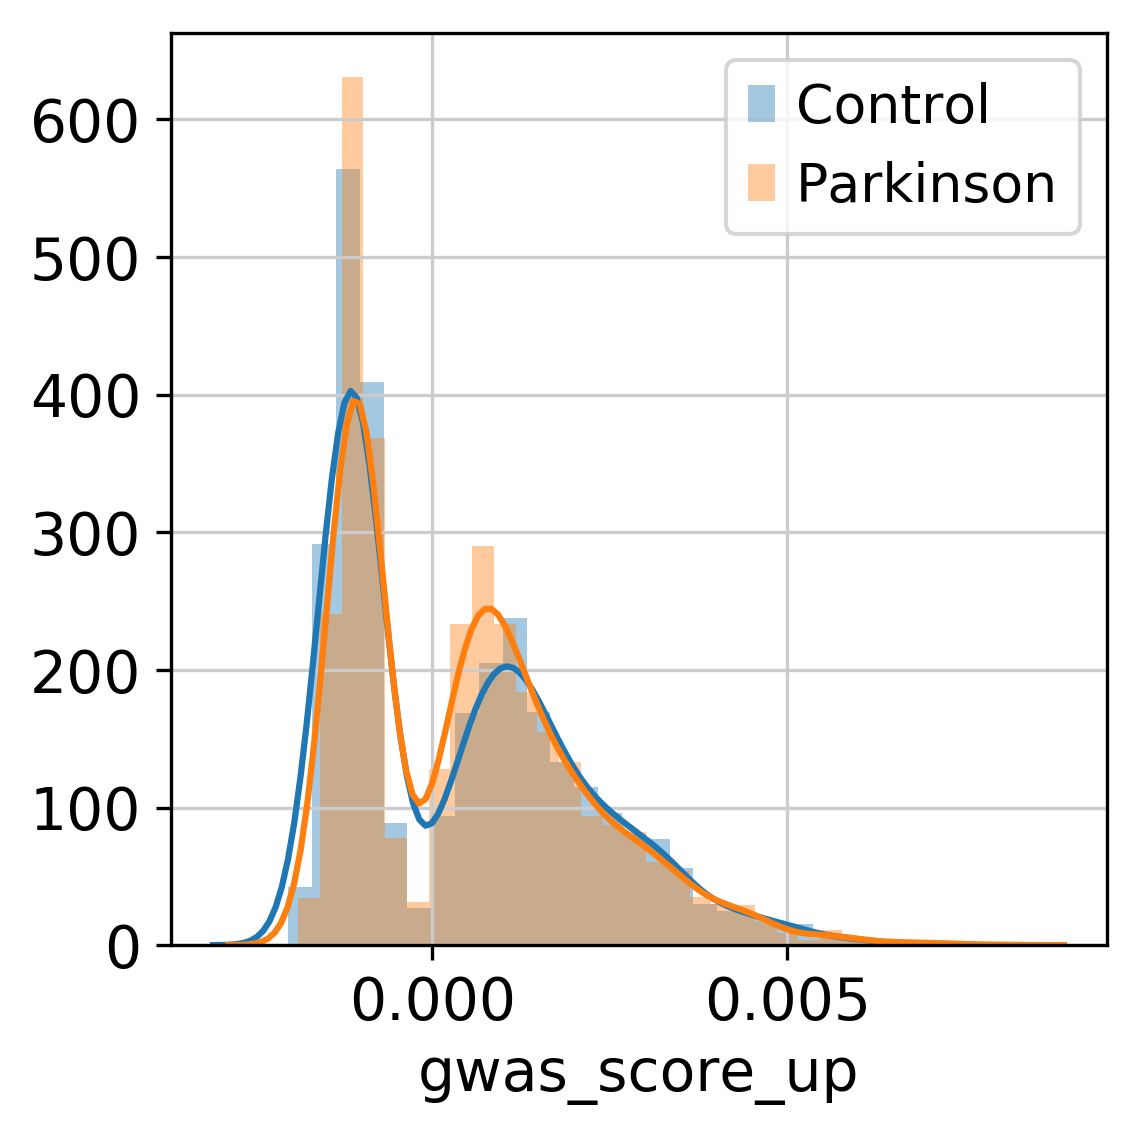

In [144]:
sb.distplot(dat1)
sb.distplot(dat2)
plt.legend(cats)

In [145]:
df = pd.DataFrame(index=adata_sub.obs_names)
df['values'] = adata_sub.obs[obs]
df['condition'] = adata_sub.obs['condition']
df['ranks'] = df['values'].rank()

In [146]:
df.groupby('condition')['values'].mean()

condition
Control      0.000392
Parkinson    0.000480
Name: values, dtype: float32

In [147]:
df.groupby('condition')['values'].median()

condition
Control      0.000248
Parkinson    0.000424
Name: values, dtype: float32

In [148]:
df.groupby('condition')['ranks'].mean()

condition
Control      3716.553742
Parkinson    3901.774534
Name: ranks, dtype: float64

## Apop. NCSC

### GWAS score down

In [149]:
# Test NCSC-apop:
cluster_key = 'louvain_final'
clust = 'Apop. NCSC'
condition = 'condition'
obs = 'gwas_score_down'
cats = adata.obs[condition].cat.categories
adata_sub = adata[adata.obs[cluster_key].isin([clust])]
dat1 = adata_sub[adata_sub.obs[condition] == cats[0]].obs[obs]
dat2 = adata_sub[adata_sub.obs[condition] == cats[1]].obs[obs]

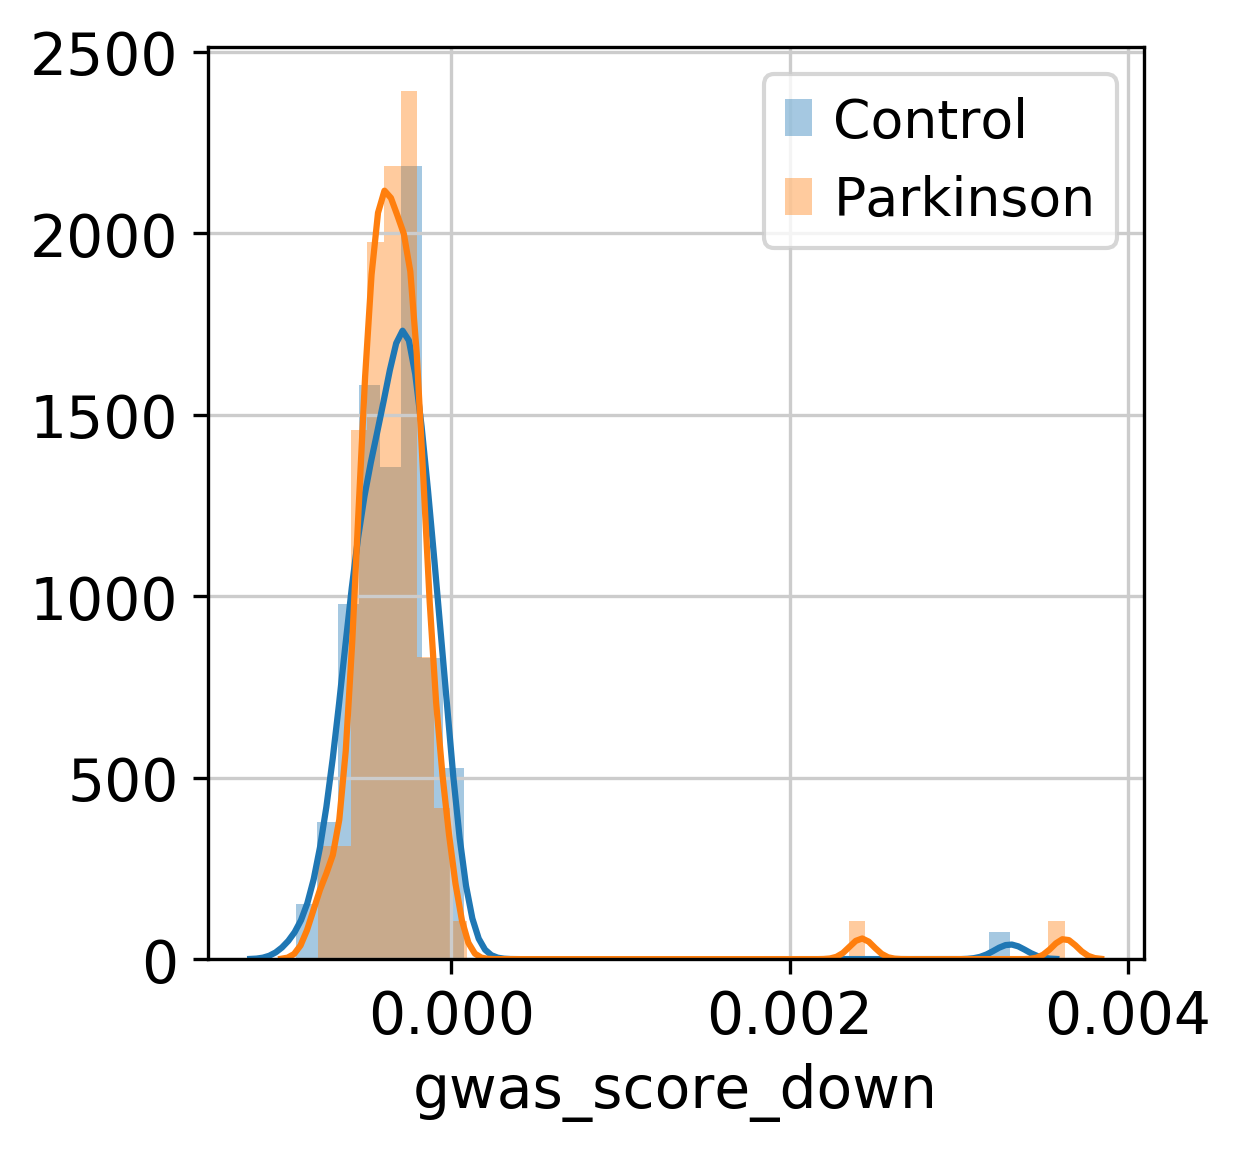

In [150]:
sb.distplot(dat1)
sb.distplot(dat2)
plt.legend(cats)

In [151]:
df = pd.DataFrame(index=adata_sub.obs_names)
df['values'] = adata_sub.obs[obs]
df['condition'] = adata_sub.obs['condition']
df['ranks'] = df['values'].rank()

In [152]:
df.groupby('condition')['values'].mean()

condition
Control     -0.000317
Parkinson   -0.000288
Name: values, dtype: float32

In [153]:
df.groupby('condition')['values'].median()

condition
Control     -0.000306
Parkinson   -0.000360
Name: values, dtype: float32

In [154]:
df.groupby('condition')['ranks'].mean()

condition
Control      104.037383
Parkinson    101.867347
Name: ranks, dtype: float64

### GWAS score up

In [155]:
# Test NCSC - apop:
cluster_key = 'louvain_final'
clust = 'Apop. NCSC'
condition = 'condition'
obs = 'gwas_score_up'
cats = adata.obs[condition].cat.categories
adata_sub = adata[adata.obs[cluster_key].isin([clust])]
dat1 = adata_sub[adata_sub.obs[condition] == cats[0]].obs[obs]
dat2 = adata_sub[adata_sub.obs[condition] == cats[1]].obs[obs]

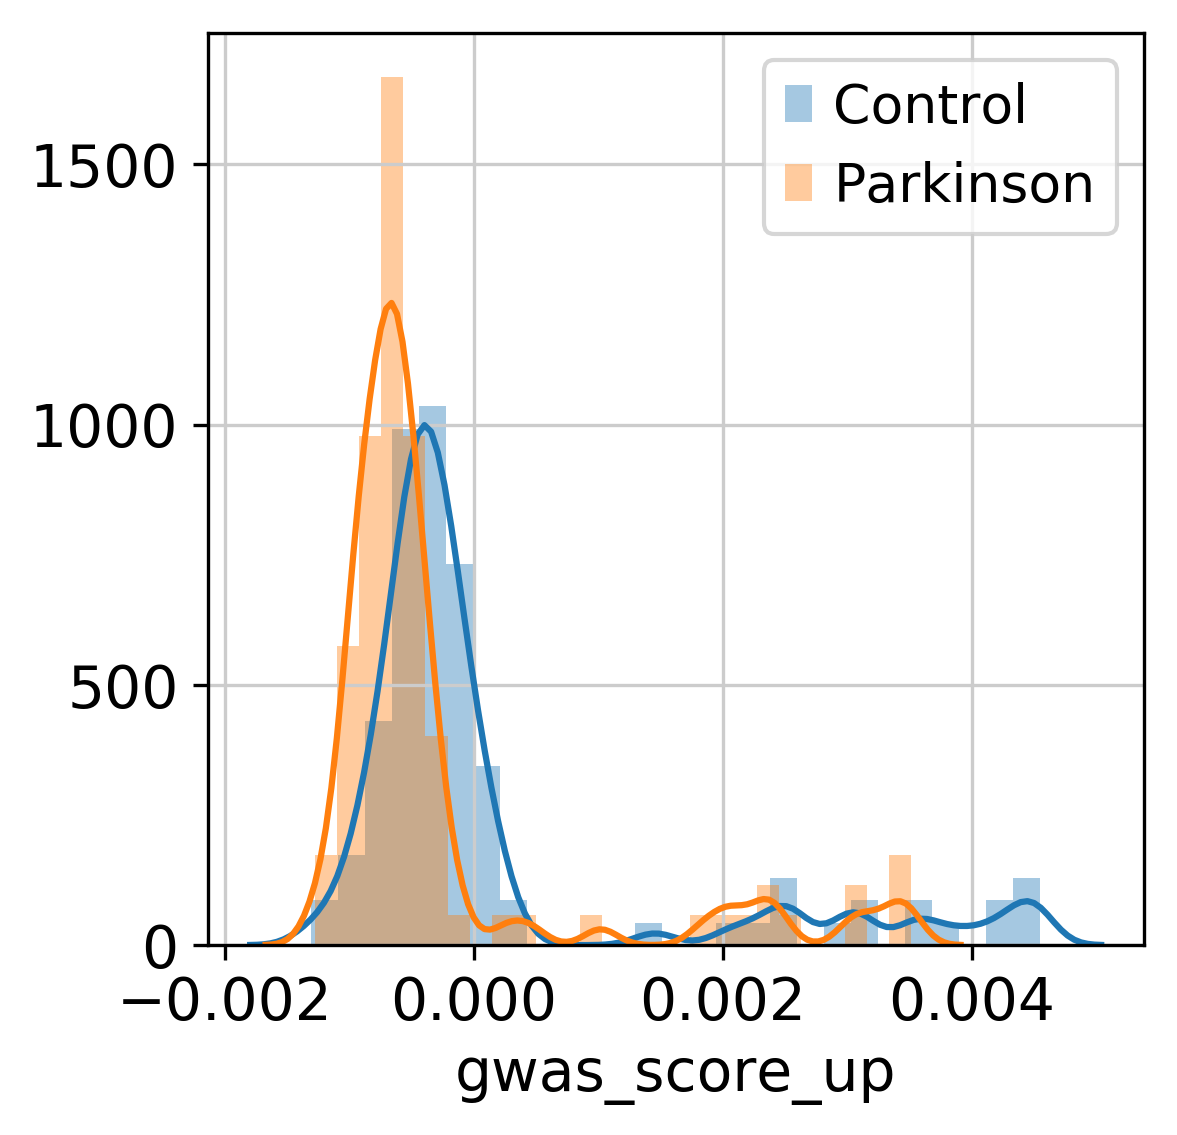

In [156]:
sb.distplot(dat1)
sb.distplot(dat2)
plt.legend(cats)

In [157]:
df = pd.DataFrame(index=adata_sub.obs_names)
df['values'] = adata_sub.obs[obs]
df['condition'] = adata_sub.obs['condition']
df['ranks'] = df['values'].rank()

In [158]:
df.groupby('condition')['values'].mean()

condition
Control      0.000182
Parkinson   -0.000268
Name: values, dtype: float32

In [159]:
df.groupby('condition')['values'].median()

condition
Control     -0.000338
Parkinson   -0.000647
Name: values, dtype: float32

In [160]:
df.groupby('condition')['ranks'].mean()

condition
Control      123.953271
Parkinson     80.122449
Name: ranks, dtype: float64